# 2. EDA

In [2]:
import io
import os
import json
import pandas as pd
import numpy as np
from scipy import stats
import random
import distutils.dir_util
from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.font_manager as fm
from collections import Counter
import string
from datetime import datetime

fe = fm.FontEntry(
    fname=r'./font/NanumGothic.ttf', name='NanumGothic')                       
fm.fontManager.ttflist.insert(0, fe)              # Matplotlib에 폰트 추가
plt.rcParams.update({'font.size': 10, 'font.family': 'NanumGothic'}) 

In [3]:
playlists = pd.read_json('../0_data/playlists.json', typ = 'frame', encoding='utf-8')
song_meta = pd.read_json('../0_data/song_meta.json', typ = 'frame', encoding='utf-8') 
genre_gn_all = pd.read_json('../0_data/genre_gn_all.json', typ = 'frame', encoding='utf-8', orient='index')

## 1) Song Meta & Genre

> Genre

- 대분류 장르, 세부 장르 비교

In [15]:
# genre_gn_all 확인
genre_gn_all.head()

,0
GN0100,발라드
GN0101,세부장르전체
GN0102,'80
GN0103,'90
GN0104,'00


In [16]:
# genre_gn_all의 컬럼 네임 지정

genre_gn_all = genre_gn_all.reset_index().rename(columns={'index':'gnr_code', 0:'gnr_name'})
genre_gn_all.head()

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0101,세부장르전체
2,GN0102,'80
3,GN0103,'90
4,GN0104,'00


In [17]:
# 대분류 장르코드들만 뽑기
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:]=='00']

# 소분류 장르코드만 뽑기
dtl_gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] != '00']
dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)

# 대분류 장르코드와 소분류 장르코드 각각의 앞자리 네자리 공통코드 추출
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])
dtl_gnr_code = dtl_gnr_code.assign(join_code = dtl_gnr_code['dtl_gnr_code'].str[0:4])

# join_code(네자리 공통코드) 기준으로 Merge
gnr_code_tree = pd.merge(gnr_code, dtl_gnr_code, how = 'left', on = 'join_code')

gnr_code_tree[['gnr_code', 'gnr_name', 'dtl_gnr_code', 'dtl_gnr_name']]
gnr_code_tree

C:\Users\cg063\AppData\Local\Temp\ipykernel_14356\906477822.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dtl_gnr_code.rename(columns = {'gnr_code' : 'dtl_gnr_code', 'gnr_name' : 'dtl_gnr_name'}, inplace = True)


,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
0,GN0100,발라드,GN01,GN0101,세부장르전체
1,GN0100,발라드,GN01,GN0102,'80
2,GN0100,발라드,GN01,GN0103,'90
3,GN0100,발라드,GN01,GN0104,'00
4,GN0100,발라드,GN01,GN0105,'10-
...,...,...,...,...,...
220,GN2800,뮤직테라피,GN28,GN2806,반려동물
221,GN2900,뮤지컬,GN29,GN2901,세부장르전체
222,GN2900,뮤지컬,GN29,GN2902,국내뮤지컬
223,GN2900,뮤지컬,GN29,GN2903,국외뮤지컬


In [18]:
# 대분류 장르에는 어떤 소분류 장르가 있는지 확인
gnr_code_tree.groupby('gnr_name')['dtl_gnr_name'].apply(list).reset_index()

,gnr_name,dtl_gnr_name
0,CCM,"[세부장르전체, 국내CCM, 국외CCM, 워십, 찬송가, 성가, 연주곡, 어린이, ..."
1,EDM,"[세부장르전체, 하우스, 클럽, DJ]"
2,J-POP,"[세부장르전체, POP, 록, 일렉트로니카, 랩/힙합, R&B/Soul, 시부야케이..."
3,OST,"[세부장르전체, 국내영화, 국외영화, 국내드라마, 국외드라마, 애니메이션/게임, 국..."
4,POP,"[세부장르전체, 얼터너티브팝, 올디스, 월드팝, '60-'70, '80-'90, '..."
5,R&B/Soul,"[세부장르전체, 어반, R&B, 세부장르전체, 컨템포러리 R&B, 소울, 어반, '..."
6,국악,"[세부장르전체, 크로스오버, 국악가요, 민요, 판소리/단가, 풍물/사물놀이]"
7,뉴에이지,"[세부장르전체, 이지리스닝, J-Newage, 기능성음악, 기타, 피아노, 컴필레이션]"
8,댄스,"[세부장르전체, '80, '90, '00, '10-]"
9,랩/힙합,"[세부장르전체, 랩 스타일, 보컬 스타일, 언더그라운드 힙합, 시대별, 세부장르전체..."


In [19]:
gnr_code_tree['gnr_code'].nunique() # 30개
gnr_code_tree['dtl_gnr_code'].nunique() # 224개

224

In [20]:
# 대분류 코드 중 중복 내용 확인
big_gnr = gnr_code_tree[['gnr_code', 'gnr_name']]
big_gnr = big_gnr.drop_duplicates()
big_gnr.reset_index(inplace=True, drop=True)
big_gnr

,gnr_code,gnr_name
0,GN0100,발라드
1,GN0200,댄스
2,GN0300,랩/힙합
3,GN0400,R&B/Soul
4,GN0500,인디음악
5,GN0600,록/메탈
6,GN0700,성인가요
7,GN0800,포크/블루스
8,GN0900,POP
9,GN1000,록/메탈


In [21]:
# 크리스마스 대분류 코드 소분류 내용 없음
gnr_code_tree[gnr_code_tree['gnr_name'] == '크리스마스']

,gnr_code,gnr_name,join_code,dtl_gnr_code,dtl_gnr_name
224,GN3000,크리스마스,GN30,NaN,NaN


-> 대분류 코드 중 일부 중복 :R&B/Soul(GN0400, GN1300), 록/메탈(GN0600, GN1000)  
-> 대분류 코드 중 크리스마스(GN3000)는 소분류 코드 X

> Song Meta 

- 오류 날짜 확인

C:\Users\cg063\AppData\Local\Temp\ipykernel_16772\1253507143.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)
C:\Users\cg063\AppData\Local\Temp\ipykernel_16772\1253507143.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
C:\Users\cg063\AppData\Local\Temp\ipykernel_16772\1253507143.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice 

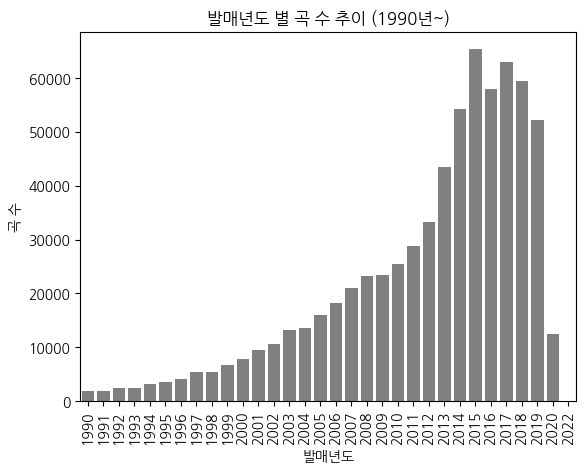

In [10]:
# 1. 곡 아이디(id)와 발매일자(issue_date) 추출
song_issue_date = song_meta[['id', 'issue_date']]
song_issue_date['issue_date'] = song_issue_date['issue_date'].astype(str)

# 2. issue_date의 앞자리 네 자리를 추출하여 발매년도(issue_year) 변수 생성
song_issue_date['issue_year'] = song_issue_date['issue_date'].str[0:4]
song_issue_date.rename(columns = {'id' : 'song_id'}, inplace = True)
song_issue_date['song_id'] = song_issue_date['song_id'].astype(str)

# 3. 1990년도~ 필터링
song_issue_date_filter = song_issue_date[song_issue_date.issue_year >= '1990']

# 4. 발매년도 별 곡 수 count 테이블 생성 : issue_year_song_cnt
issue_year_song_cnt = song_issue_date_filter.groupby('issue_year').song_id.nunique().reset_index(name = 'song_cnt')

# 5. plotting
issue_year_song_cnt_plot = sns.barplot(x = 'issue_year', y = 'song_cnt', data = issue_year_song_cnt, color = 'grey')
issue_year_song_cnt_plot.set_title('발매년도 별 곡 수 추이 (1990년~)')
issue_year_song_cnt_plot.set_xlabel('발매년도')
issue_year_song_cnt_plot.set_ylabel('곡 수')
plt.xticks(rotation = 90)
plt.show()

In [11]:
song_meta[song_meta['issue_date'] > 20200500]

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
141185,[GN1801],20220113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],잔잔한 바람이 불어와 (There is a gentle breeze),[GN1800],[무드홀릭 (Moodholic)],141185
448286,[GN1801],20220113,고요한 밤바다 구경하기 [여수 바다],10403230,[2737142],여수 바다 (Yeosu sea),[GN1800],[무드홀릭 (Moodholic)],448286


=> 오류 날짜 수정해야 함

- 노래 별 장르 분포 확인

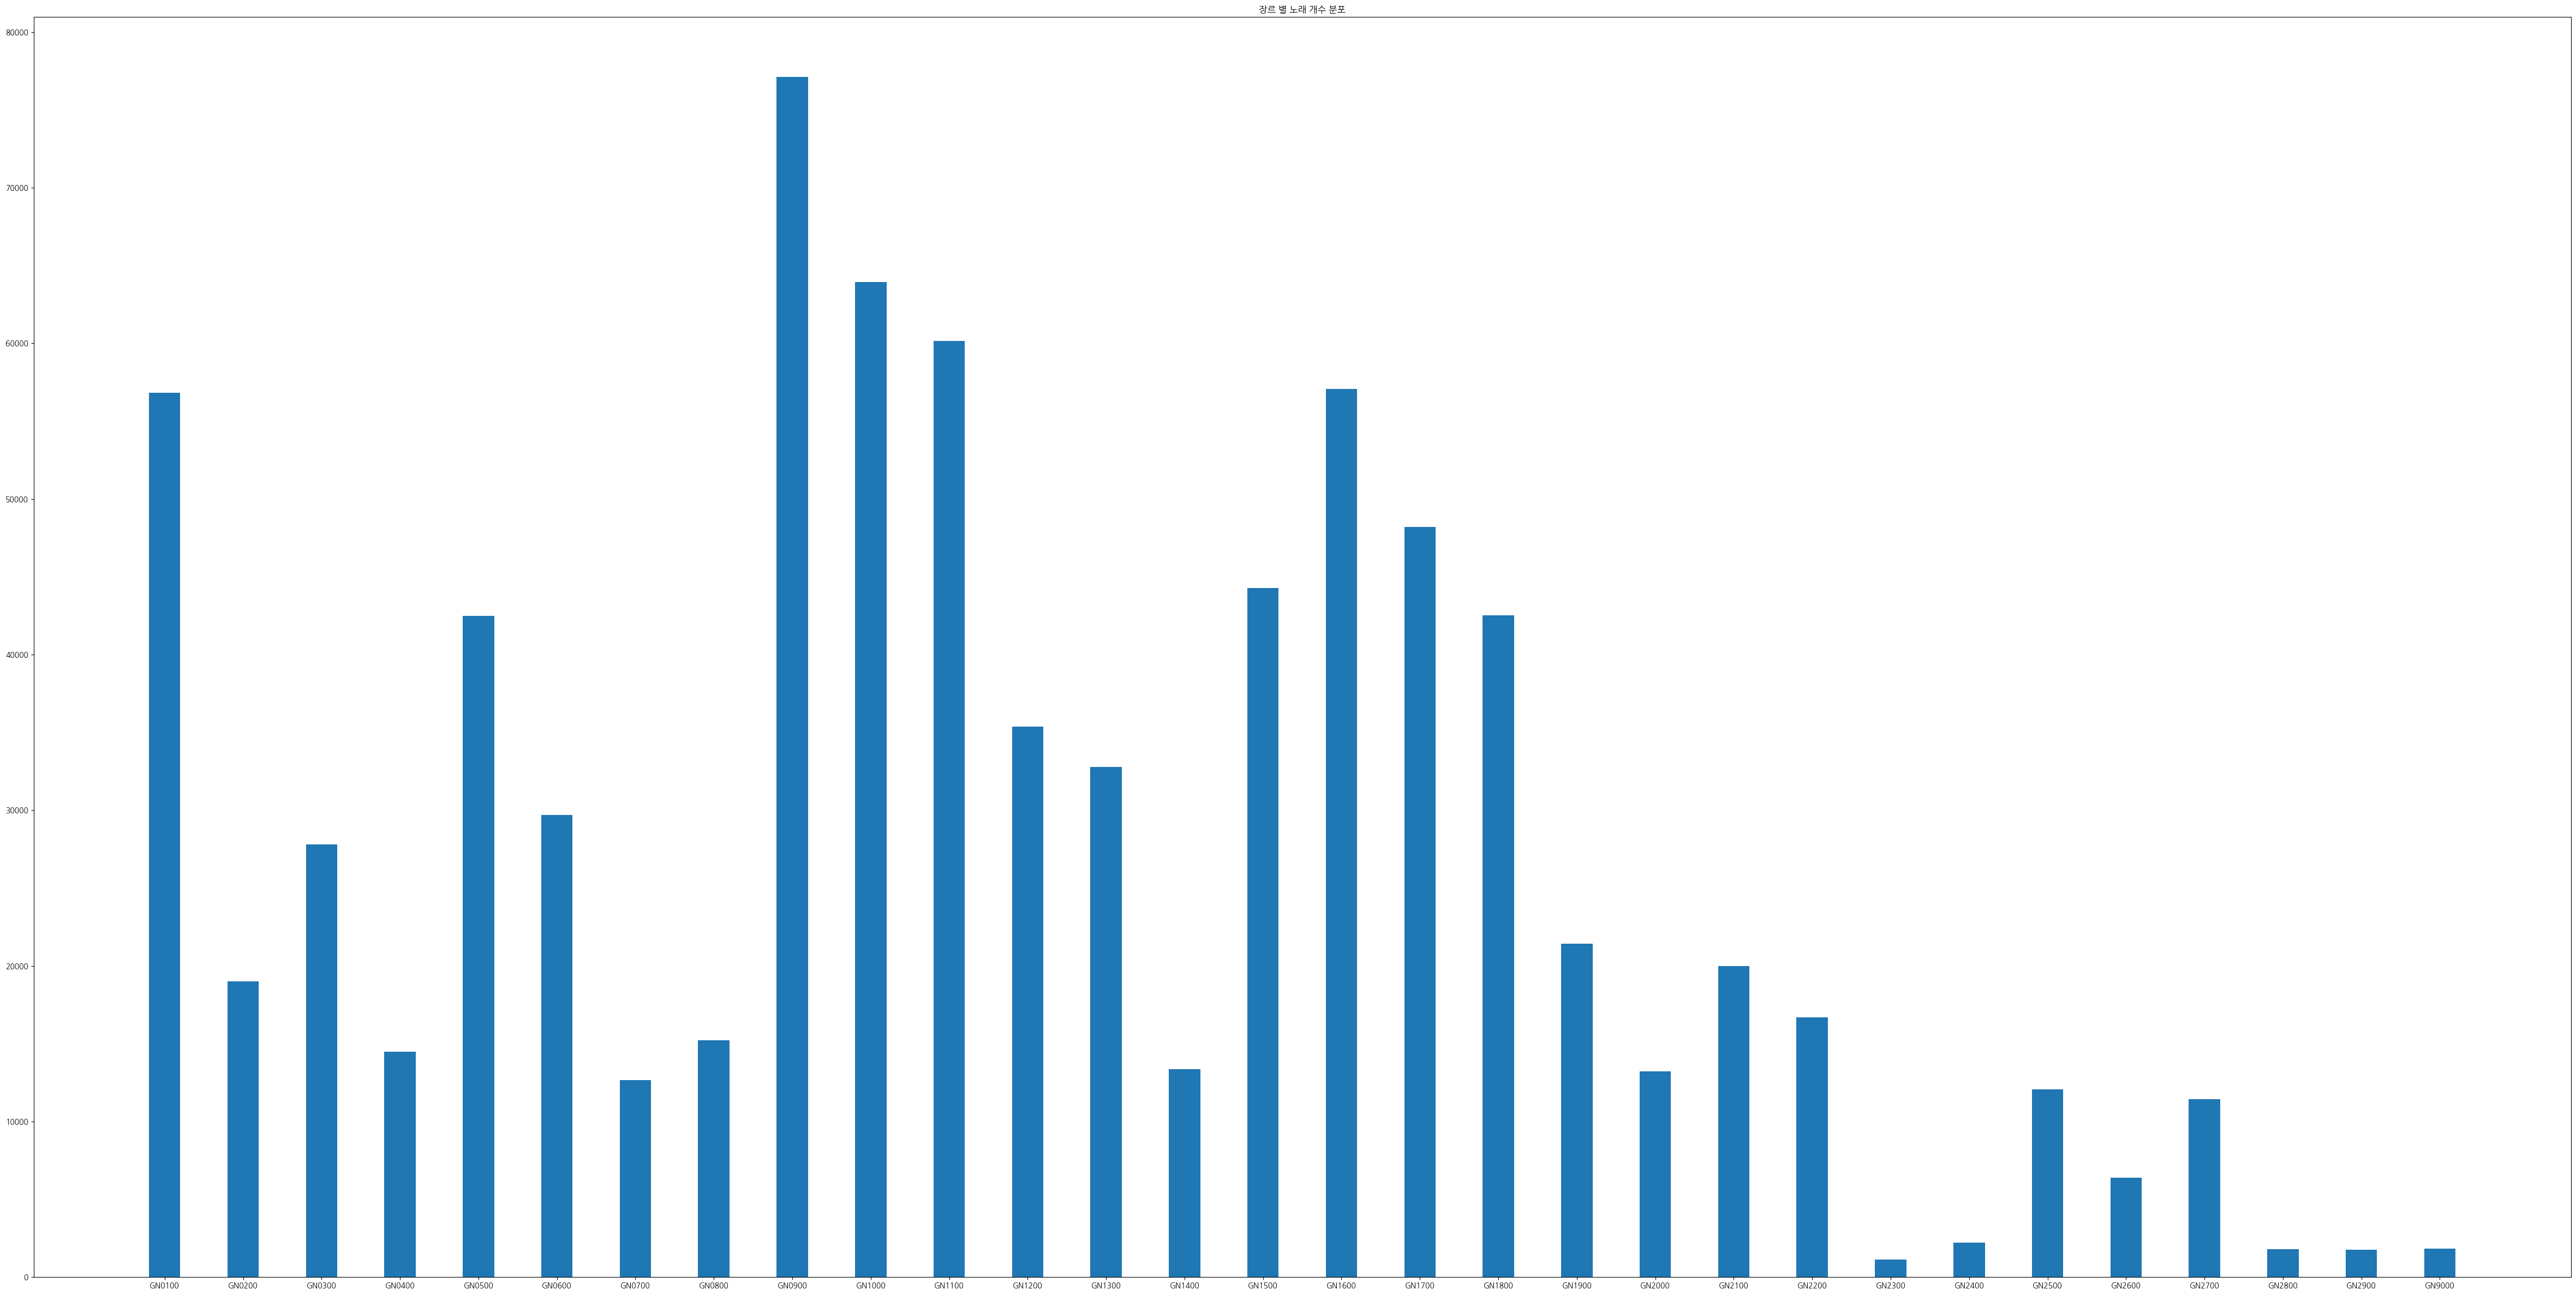

In [12]:
song_gnr = song_meta.explode('song_gn_gnr_basket').groupby('song_gn_gnr_basket')['id'].count().reset_index().rename(columns={'song_gn_gnr_basket':'song_gnr', 'id':'id_cnt'})

plt.figure(figsize=(60, 30))
plt.bar(song_gnr['song_gnr'], song_gnr['id_cnt'], width=0.4)
plt.title('장르 별 노래 개수 분포')
plt.rc('font', size=30)  
plt.rc('xtick', labelsize=30) 
plt.rc('ytick', labelsize=20) 

In [13]:
gnr_outlier = song_meta.explode('song_gn_gnr_basket')
gnr_outlier[gnr_outlier['song_gn_gnr_basket'] == 'GN9000']

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id
262,[],20150318,노년의 건강을 지켜주는 음악 처방전 (부제 : 휴식 때 들으면 좋은 음악친구),2309524,[726909],Bio Sound `Breathing & Big Bell`,GN9000,[차병원],262
916,[],20170825,크리스마스의 기적,10090652,[750416],Springtime In December,GN9000,[Larry Warren],916
1074,[],20131128,Open It Up,10008901,[1221466],Open It Up,GN9000,[Tchengiz],1074
2205,[],20161130,크리스마스 하프 감성 연주곡 베스트,10019367,[923656],고요한 밤 거룩한 밤 (Silent Night Holy Night) (크리스마스 하프),GN9000,[크리스마스 캐롤송],2205
3973,[],20181210,크리스마스 재즈 캐롤 노래 연주곡 캐롤송 메들리,10230803,[2403083],The First Noel (Jazz),GN9000,[크리스마스],3973
...,...,...,...,...,...,...,...,...,...
706172,[],20190924,여행(Travel),10331385,[2739231],여행(Travel),GN9000,[카무 (Kamoo)],706172
706502,[],20110831,엄마와 아가와의 행복한 대화 태교음악 뉴에이지,2009854,[561734],Love Love Love,GN9000,[해피타임뮤직],706502
706716,[],20200109,Have It All,10373946,[2762722],Have It All,GN9000,[Renegade],706716
707201,[],20200115,모두의 MR반주 123,10376105,[770787],Into the Unknown (겨울왕국 2 OST) (Melody MR),GN9000,[모두의MR],707201


=> GN9000 장르를 가진 song 삭제

- song_meta 내 장르 분포

In [74]:
song_gnr = pd.merge(song_meta.explode('song_gn_gnr_basket'), big_gnr, left_on='song_gn_gnr_basket', right_on='gnr_code')
song_gnr.head()

,song_gn_dtl_gnr_basket,issue_date,album_name,album_id,artist_id_basket,song_name,song_gn_gnr_basket,artist_name_basket,id,gnr_code,gnr_name
0,[GN0901],20140512,불후의 명곡 - 7080 추억의 얄개시대 팝송베스트,2255639,[2727],Feelings,GN0900,[Various Artists],0,GN0900,POP
1,[GN0901],20180518,Hit,4698747,[3361],Solsbury Hill (Remastered 2002),GN0900,[Peter Gabriel],2,GN0900,POP
2,[GN0901],20191023,Earth Glow,10341972,[896417],Can&#39;t Stand Still,GN0900,[Ruelle],16,GN0900,POP
3,"[GN0906, GN0901, GN0903]",19960723,16 Most Requested Songs,304254,[5985],"Hush, Hush, Sweet Charlotte",GN0900,[Patti Page],22,GN0900,POP
4,[GN0901],20100924,2010 CF 배경음악 Vol. 1,1030176,[2727],Move It Like This (Remake Ver.),GN0900,[Various Artists],26,GN0900,POP


In [123]:
# 플레이리스트 내 장르 분포 확인

print(len(Counter(song_gnr['gnr_name'])))
song_gnr_count = Counter(song_gnr['gnr_name'])
song_gnr_count_key = list(song_gnr_count.keys())[:10]
song_gnr_count_val = list(song_gnr_count.values())[:10]

25


In [124]:
song_gnr_count_val

[77101, 57066, 66544, 42515, 48199, 63160, 56820, 47260, 11440, 12066]

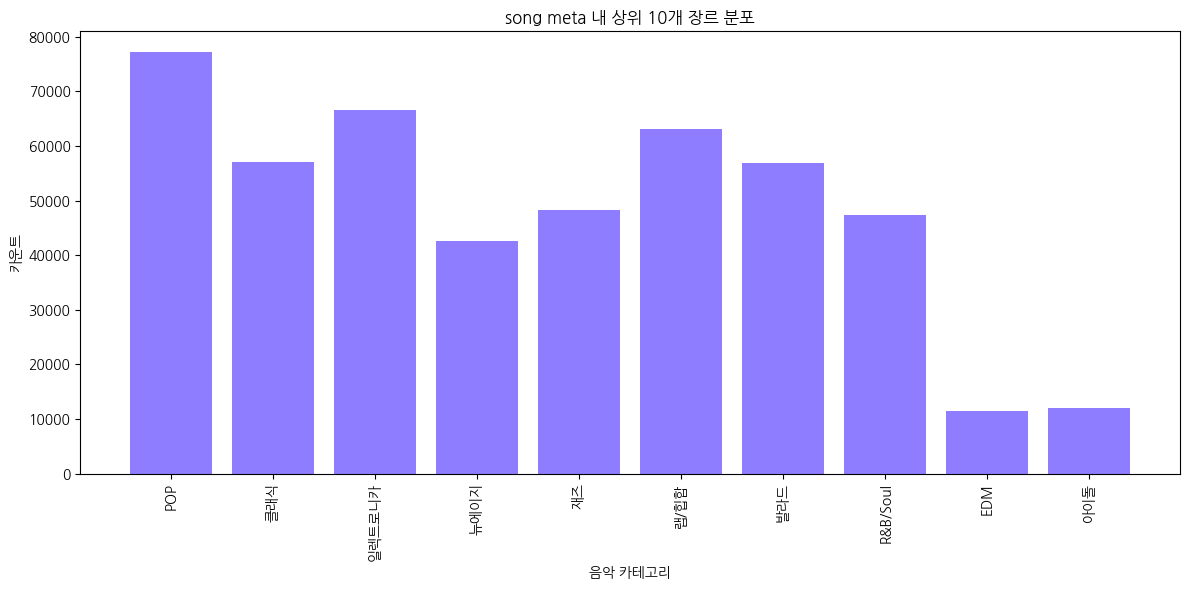

In [125]:
# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(song_gnr_count_key[:10], song_gnr_count_val, color='#8E7EFF')
plt.xlabel('음악 카테고리')
plt.ylabel('카운트')
plt.title('song meta 내 상위 10개 장르 분포')
plt.xticks(rotation=90)  # 카테고리 레이블을 90도 회전하여 가독성 향상
plt.tight_layout()  # 그래프 요소들이 잘리지 않도록 조정

# 그래프 표시
plt.show()

## 2) Playlists

- playlists 내 사용된 장르 분포 확인

In [53]:
# playlists에 대분류 장르 코드 컬럼 추가
ply_sm = pd.merge(playlists, song_meta[['id', 'song_gn_gnr_basket']]) # 115071행
ply_gnr = pd.merge(ply_sm.explode('song_gn_gnr_basket'), big_gnr, left_on='song_gn_gnr_basket', right_on='gnr_code')
ply_gnr.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,song_gn_gnr_basket,gnr_code,gnr_name
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,GN2600,GN2600,일렉트로니카
1,[댄스],62696,★☆기분좋은 여름날☆★,"[10650, 331003, 637352, 683765, 114792, 509484...",1,2008-07-21 15:46:06.000,GN2600,GN2600,일렉트로니카
2,"[Moti, Kshmr, UMF, DVBBS, MartinGarrix]",116207,U.M.F에 온 것 같은 느낌을 주는 EDM,"[162404, 584986, 17052, 281595, 311891, 77010,...",7,2018-05-05 22:19:30.000,GN2600,GN2600,일렉트로니카
3,"[여름, 설렘, 사랑]",1657,너의 목소리가 들려ost 번외편,"[162534, 509629, 611695, 383498, 120159, 40066...",12,2013-08-29 08:11:34.000,GN2600,GN2600,일렉트로니카
4,"[힙합, 팝, 즐겨드는, 일렉]",1731,매장에서 듣고 싶은 노래,"[261823, 19821, 677953, 456098, 258899, 113419...",5,2016-03-29 23:35:57.000,GN2600,GN2600,일렉트로니카


In [54]:
# 필요한 행만 남기기
ply_gnr.drop(columns =['song_gn_gnr_basket'], inplace=True)

In [55]:
ply_gnr.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130086 entries, 0 to 130085
Data columns (total 8 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   tags          130086 non-null  object
 1   id            130086 non-null  int64 
 2   plylst_title  130086 non-null  object
 3   songs         130086 non-null  object
 4   like_cnt      130086 non-null  int64 
 5   updt_date     130086 non-null  object
 6   gnr_code      130086 non-null  object
 7   gnr_name      130086 non-null  object
dtypes: int64(2), object(6)
memory usage: 8.9+ MB


In [126]:
# 플레이리스트 내 장르 분포 확인

print(len(Counter(ply_gnr['gnr_name'])))
ply_gnr_count = Counter(ply_gnr['gnr_name'])
ply_gnr_count_key = list(ply_gnr_count.keys())[:10]
ply_gnr_count_val = list(ply_gnr_count.values())[:10]

25


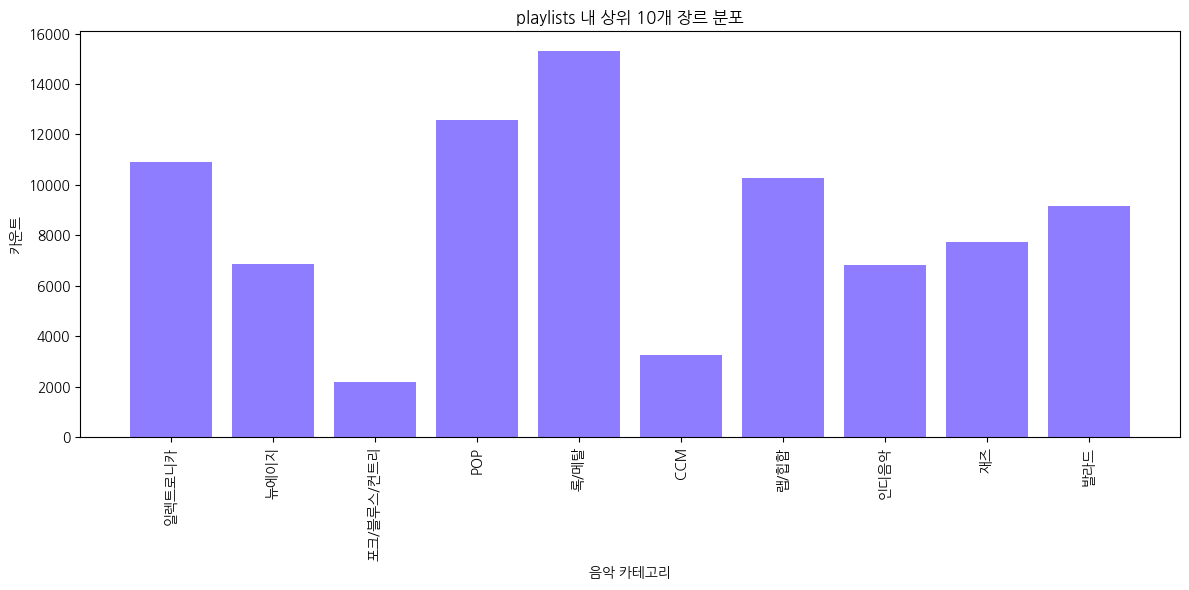

In [127]:
# 막대 그래프 그리기
plt.figure(figsize=(12, 6))
plt.bar(ply_gnr_count_key, ply_gnr_count_val, color='#8E7EFF')
plt.xlabel('음악 카테고리')
plt.ylabel('카운트')
plt.title('playlists 내 상위 10개 장르 분포')
plt.xticks(rotation=90)  # 카테고리 레이블을 90도 회전하여 가독성 향상
plt.tight_layout()  # 그래프 요소들이 잘리지 않도록 조정

# 그래프 표시
plt.show()

In [ ]:
pl

> 플레이리스트 내 곡들의 평균 발매일

- 가장 오래된 노래의 발매일, 가장 최신 노래의 발매일, 평균

In [14]:
# 플레이리스트와 song_meta의 issue_date merge
song_meta_issue_date = song_meta[['issue_date', 'id']]
ply_song = playlists.explode('songs')
ply_song_issue_date = pd.merge(ply_song, song_meta_issue_date, how='left', left_on='songs', right_on='id')

# 플레이리스트 id 기준으로 songs, issue_date 하나의 리스트에 담기
grouped_ply = ply_song_issue_date.groupby('id_x').agg({'songs': list, 'issue_date': list}).reset_index()

# 플레이리스트 id 기준으로 원래 playlists와 merge
playlists_date = pd.merge(playlists, grouped_ply, how='left', left_on='id', right_on='id_x')
playlists_date = playlists_date[['tags', 'id', 'plylst_title', 'songs_x', 'like_cnt', 'updt_date', 'issue_date']]
playlists_date

,tags,id,plylst_title,songs_x,like_cnt,updt_date,issue_date
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[20130506, 20130917, 19911021, 20000919, 20050..."
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[20030314, 20061204, 20061204, 20071023, 20080..."
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[20081029, 20081029, 20140818, 20141126, 20141..."
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[20191115, 19981201, 20061124, 20101102, 20101..."
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[20010619, 19970520, 19970514, 19940900, 20020..."
...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"[20040117, 20011108, 20011108, 20011108, 20001..."
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,"[20151208, 20151216, 20150224, 20150820, 20150..."
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"[20170216, 20190409, 20070608, 20080403, 20080..."
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"[19980116, 20030407, 20060706, 20091016, 20100..."


In [15]:
playlists_date['date_old'] = playlists_date['issue_date'].apply(min) # 가장 오래된 노래 발매일
playlists_date['date_new'] = playlists_date['issue_date'].apply(max) # 가장 최신 노래 발매일
playlists_date

,tags,id,plylst_title,songs_x,like_cnt,updt_date,issue_date,date_old,date_new
0,[락],61281,여행같은 음악,"[525514, 129701, 383374, 562083, 297861, 13954...",71,2013-12-19 18:36:19.000,"[20130506, 20130917, 19911021, 20000919, 20050...",19911021,20131122
1,"[추억, 회상]",10532,요즘 너 말야,"[432406, 675945, 497066, 120377, 389529, 24427...",1,2014-12-02 16:19:42.000,"[20030314, 20061204, 20061204, 20071023, 20080...",20030314,20141020
2,"[까페, 잔잔한]",76951,"편하게, 잔잔하게 들을 수 있는 곡.-","[83116, 276692, 166267, 186301, 354465, 256598...",17,2017-08-28 07:09:34.000,"[20081029, 20081029, 20140818, 20141126, 20141...",20081029,20170110
3,"[연말, 눈오는날, 캐럴, 분위기, 따듯한, 크리스마스캐럴, 겨울노래, 크리스마스,...",147456,크리스마스 분위기에 흠뻑 취하고 싶을때,"[394031, 195524, 540149, 287984, 440773, 10033...",33,2019-12-05 15:15:18.000,"[20191115, 19981201, 20061124, 20101102, 20101...",19981201,20191115
4,[댄스],27616,추억의 노래 ㅋ,"[159327, 553610, 5130, 645103, 294435, 100657,...",9,2011-10-25 13:54:56.000,"[20010619, 19970520, 19970514, 19940900, 20020...",19940301,20090824
...,...,...,...,...,...,...,...,...,...
115066,"[록메탈, 밴드사운드, 록, 락메탈, 메탈, 락, extreme]",120325,METAL E'SM #2,"[429629, 441511, 612106, 516359, 691768, 38714...",3,2020-04-17 04:31:11.000,"[20040117, 20011108, 20011108, 20011108, 20001...",19920609,20180101
115067,[일렉],106976,빠른 리스너를 위한 따끈따끈한 최신 인기 EDM 모음!,"[321330, 216057, 534472, 240306, 331098, 23288...",13,2015-12-24 17:23:19.000,"[20151208, 20151216, 20150224, 20150820, 20150...",20150224,20151216
115068,"[담시, 가족, 눈물, 그리움, 주인공, 나의_이야기, 사랑, 친구]",11343,#1. 눈물이 앞을 가리는 나의_이야기,"[50512, 249024, 250608, 371171, 229942, 694943...",4,2019-08-16 20:59:22.000,"[20170216, 20190409, 20070608, 20080403, 20080...",20070608,20190409
115069,"[잔잔한, 버스, 퇴근버스, Pop, 풍경, 퇴근길]",131982,퇴근 버스에서 편히 들으면서 하루를 마무리하기에 좋은 POP,"[533534, 608114, 343608, 417140, 609009, 30217...",4,2019-10-25 23:40:42.000,"[19980116, 20030407, 20060706, 20091016, 20100...",19980116,20190621


In [16]:
# 가장 오래된 노래
min_value = playlists_date['date_new'].min() # 0
next_min_value = playlists_date['date_new'][playlists_date['date_new'] > min_value].min() # 19731100
playlists_date['date_new'][playlists_date['date_new'] > next_min_value].min() #19750201

19750201

In [17]:
# 가장 최신 노래
print(playlists_date['date_new'].max())# 20220113

20220113


> 중복 타이틀 확인

In [18]:
# 1. 플레이리스트 아이디(id)와 플레이리스트 명(plylst_title) 추출
plylst_title = playlists[['id', 'plylst_title']]

# 2. 플레이리스트 이름 별 플레이리스트 ID count 테이블 생성 : plylst_id_cnt
plylst_id_cnt = plylst_title.groupby('plylst_title').id.nunique().reset_index(name = 'mapping_plylst_cnt')

# 3. 플레이리스트 명 중복 구분 : 서로 다른 플레이리스트 아이디로 겹치는 플레이리스트 이름이 없으면 '중복 없음', 그 외 '중복 있음'
plylst_id_cnt = plylst_id_cnt.assign(
    mapping_plylst_cnt_category = pd.cut(plylst_id_cnt['mapping_plylst_cnt'], [0, 1, np.inf], labels = ['중복 없음', '중복 있음'])
)
plylst_id_cnt
# [0, 1, np.inf] : 0이상 1미만 값 = 중복없음, 1이상의 값 = 중복있음

# 4. 중복 구분 별 플레이리스트 수 count 테이블 생성 : plylst_id_cnt_division
plylst_id_cnt_division = pd.DataFrame(plylst_id_cnt.groupby('mapping_plylst_cnt_category').count())
plylst_id_cnt_division


,plylst_title,mapping_plylst_cnt
mapping_plylst_cnt_category,,
중복 없음,108214,108214
중복 있음,2317,2317


=> 전체의 2.09%는 같은 플레이리스트 타이틀을 갖고 있음

- 중복된 타이틀의 좋아요, 노래, 태그 개수 비교

In [19]:
# 플레이리스트 타이틀을 기준으로 merge해 중복된 플레이리스트만 확인
playlists_dup = pd.merge(playlists, plylst_id_cnt, on='plylst_title')
playlists_dup= playlists_dup[playlists_dup['mapping_plylst_cnt_category'] == '중복 있음']
playlists_dup['song_cnt'] = playlists_dup['songs'].apply(len)
playlists_dup['tag_cnt'] = playlists_dup['tags'].apply(len)
playlists_dup.head()

,tags,id,plylst_title,songs,like_cnt,updt_date,mapping_plylst_cnt,mapping_plylst_cnt_category,song_cnt,tag_cnt
16,"[감성, 질리지않는, 나만알고싶은, Pop]",1516,나만 알고싶은 노래들,"[331055, 99287, 310974, 376435, 146989, 430106...",1,2018-01-02 12:10:59.000,4,중복 있음,31,4
17,"[기분전환, 까페]",86179,나만 알고싶은 노래들,"[480142, 578916, 467225, 701072, 197046, 63557...",6,2016-10-06 02:08:40.000,4,중복 있음,46,2
18,"[숨은명곡, 좋은노래]",54673,나만 알고싶은 노래들,"[113618, 422482, 380069, 75425, 79141, 657137,...",7,2016-07-15 10:20:17.000,4,중복 있음,23,2
19,"[감성힙합, 나만알고싶은, 뿜뿜, 그루브, 노래, 감성]",135616,나만 알고싶은 노래들,"[470548, 603591, 382764, 288501, 187291, 37802...",30,2018-07-13 08:18:54.000,4,중복 있음,45,6
46,"[월드, 연주, 재즈]",109678,"영화, Jazz를 만나다 294","[134115, 150481, 2861, 321479, 252928, 360185,...",0,2019-03-27 15:29:18.000,3,중복 있음,27,3


In [20]:
# 같은 타이틀을 가진 플레이리스트의 노래 개수 비교
# playlists_dup에서 타이틀별로 groupby 후 song_cnt 값들을 song_cnt_nunique(새 컬럼)에 리스트 형태로 넣은 후 중복을 없애기 위해 set 진행
# 1의 의미는 노래 갯수가 중복되어 있다는 뜻이기 때문에 1의 갯수가 적은 지표를 기준으로 중복 플레이리스트 제거를 진행해야함

playlists_dup_song_cnt = playlists_dup.groupby('plylst_title')['song_cnt'].apply(list).reset_index()
playlists_dup_song_cnt['song_cnt_nunique'] = playlists_dup_song_cnt['song_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_song_cnt['song_cnt_nunique'])

Counter({2: 1256,
         1: 514,
         4: 110,
         3: 289,
         19: 2,
         8: 13,
         13: 3,
         16: 2,
         5: 49,
         6: 35,
         7: 18,
         14: 3,
         20: 1,
         15: 3,
         11: 5,
         9: 4,
         10: 6,
         12: 2,
         21: 1,
         18: 1})

In [21]:
# 같은 타이틀을 가진 플레이리스트의 태그 개수 비교

playlists_dup_tag_cnt = playlists_dup.groupby('plylst_title')['tag_cnt'].apply(list).reset_index()
playlists_dup_tag_cnt['tag_cnt_nunique'] = playlists_dup_tag_cnt['tag_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_tag_cnt['tag_cnt_nunique'])

Counter({1: 1180, 2: 952, 3: 121, 4: 44, 6: 8, 5: 12})

In [22]:
# 같은 타이틀을 가진 플레이리스트의 좋아요 비교

playlists_dup_like_cnt = playlists_dup.groupby('plylst_title')['like_cnt'].apply(list).reset_index()
playlists_dup_like_cnt['like_cnt_nunique'] = playlists_dup_like_cnt['like_cnt'].apply(lambda x: len(set(x)))
Counter(playlists_dup_like_cnt['like_cnt_nunique'])

Counter({2: 1482,
         1: 416,
         3: 244,
         4: 76,
         20: 1,
         7: 10,
         8: 6,
         12: 3,
         5: 42,
         6: 21,
         9: 5,
         11: 2,
         10: 5,
         14: 1,
         15: 1,
         13: 1,
         24: 1})

=> 노래 개수 or 좋아요를 많이 가진 플리로 남기자

> 불용어 확인

- 타이틀 불용어

In [23]:
# 특수문자가 많은 plylst_title을 찾는 함수 정의
def count_special_chars(title):
    count = sum(1 for char in title if char in string.punctuation)
    return count

In [24]:
# 특수문자 개수를 계산하여 새로운 컬럼 추가
playlists['special_char_count'] = playlists['plylst_title'].apply(count_special_chars)

# 특수문자 개수에 따라 데이터프레임 정렬
sorted_df = playlists.sort_values(by='special_char_count', ascending=False)

# 정렬된 데이터프레임 출력
sorted_df[['plylst_title', 'special_char_count']].head(10)

,plylst_title,special_char_count
93770,내가 아팠다고....아파 한다고....하지만 숨길수 밖에 없었던 날....그래......,28
25748,Let`s Rock!!!!!!!!!!!!!!!!!!!!!!!,24
106802,Let`s Rock!!!!!!!!!!!!!!!!!!!!!!!,24
100143,Let`s Rock!!!!!!!!!!!!!!!!!!!!!!!,24
42277,2005~2006 주름 잡았던 히트곡!!!!!!!!!!!!!!!!!!!!!!!,24
77720,나는 솔로다!!!!!!!!!!!!!!!!!!!!!!!,23
5697,반쪽짜리 사랑.....짝사랑.................,22
56134,내적댄스 터져베이베 !!!!! 아이돌 노래노래!!!@!@!!!!!!!!!,20
59162,"가을이다..\(^o^)/ ,곧 겨울이다...((T^T) ;;;;",20
19571,승훈좋아.................,17


In [25]:
playlists['tags_str'] = playlists['tags'].apply(lambda x : str(x).strip('[]'))
playlists['tags_str']

0                                                       '락'
1                                                '추억', '회상'
2                                               '까페', '잔잔한'
3         '연말', '눈오는날', '캐럴', '분위기', '따듯한', '크리스마스캐럴', '...
4                                                      '댄스'
                                ...                        
115066     '록메탈', '밴드사운드', '록', '락메탈', '메탈', '락', 'extreme'
115067                                                 '일렉'
115068    '담시', '가족', '눈물', '그리움', '주인공', '나의_이야기', '사랑'...
115069              '잔잔한', '버스', '퇴근버스', 'Pop', '풍경', '퇴근길'
115070                         '노래추천', '팝송추천', '팝송', '팝송모음'
Name: tags_str, Length: 115071, dtype: object

- 태그 불용어

In [28]:
# 해시태그 특수문자 찾는 함수 정의

def count_special_tag_chars(title):
    special_chars = string.punctuation + '_'
    count = sum(1 for char in title if char in special_chars)
    return count

# 특수문자 개수를 계산하여 새로운 컬럼 추가
playlists['special_tag_char_count'] = playlists['tags_str'].apply(count_special_tag_chars)

# 특수문자 개수에 따라 데이터프레임 정렬
sorted_df = playlists.sort_values(by='special_tag_char_count', ascending=False)

# 정렬된 데이터프레임 출력
sorted_df[['tags', 'special_tag_char_count']].head(10)

,tags,special_tag_char_count
2896,"[사실상_친구_같은_편안함, 태그는_이쯤에서_그만두죠, 발라드가_많아서_미안해요, ...",39
20705,"[나만을_위해_노래, 제이슨_므라즈, 잔잔한, 제임스_블런트, 콜드플레이, 에드_시...",36
28664,"[1960_70, 1950_60, label_crew, 2000_10, icons,...",35
61032,"[술, 너의_음성을, 보고싶다_나의당신, 기억들, 한_잔에, 너와의, 끝나지않는, ...",35
50476,"[잔잔한, 수록곡, 서은광_이민혁_이창섭_임현식, 아이돌숨은명곡들, 잘때듣는노래, ...",34
32367,"[카페_음악, 밤, space, UNIVERSE, 새벽, 우주, 방안, 조용한음악,...",34
20647,"[겨울을_준비하는, 유니크한, 카페, 신비롭고, 짙고_매혹적인_음색, 감성사운드, ...",34
81626,"[kpop, 샤워, 운동, 흐리고_비, 여행, 파워풀_에너제틱, 파티, 힘이_나는,...",34
31306,"[집중력, 음악, 카페, 공부가_잘되는_음악, 연주, 수능, 뉴에이지, 시험, 백점...",34
98163,"[응원, 출근, 새해, 기분전환, 새학기_개학, 입학, 힘이_나는, 희망, 시작_출...",33


=> 특수문자 제거, all 숫자인 타이틀을 가진 플레이리스트 삭제  
=> 불용어를 처리하고 나면 중복되는 내용이 또 있을테니, 불용어부터 처리

> 플레이리스트 별 노래, 태그 개수 확인

- 노래
    - 플레이리스트 별 곡 분포 - boxplot

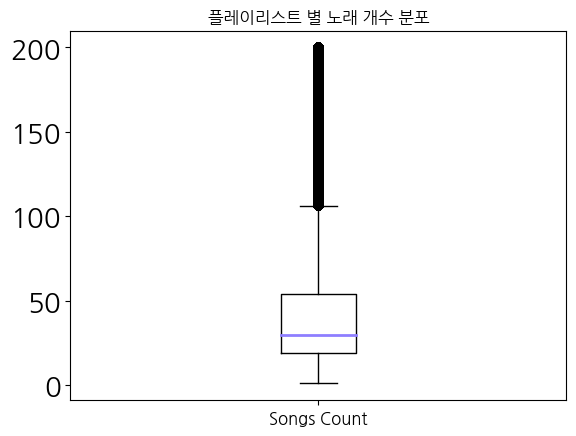

In [35]:
# 데이터 생성 예시
playlists['songs_cnt'] = playlists['songs'].apply(len)

# 박스플롯 생성
boxplot = plt.boxplot(playlists['songs_cnt'])

# 중앙값 색상 설정
for median in boxplot['medians']:
    median.set(color='#8E7EFF', linewidth=2)

plt.xticks([1], ['Songs Count'], fontsize=12)
plt.title('플레이리스트 별 노래 개수 분포', fontsize=12)

plt.show()

In [31]:
playlists['songs_cnt'].describe()

count    115071.000000
mean         45.935735
std          43.950335
min           1.000000
25%          19.000000
50%          30.000000
75%          54.000000
max         200.000000
Name: songs_cnt, dtype: float64

In [32]:
Q1 = 19
Q3 = 54
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-33.5
106.5


=> 5~106개만 남겨야 함

- 플레이리스트 별 곡 분포 - 히스토그램

In [34]:
playlists['songs_cnt'] = playlists['songs'].apply(lambda x : len(x))
playlists['songs_cnt'].describe()

count    115071.000000
mean         45.935735
std          43.950335
min           1.000000
25%          19.000000
50%          30.000000
75%          54.000000
max         200.000000
Name: songs_cnt, dtype: float64

(array([    0., 10000., 20000., 30000., 40000.]),
 [Text(0, 0.0, '0'),
  Text(0, 10000.0, '10000'),
  Text(0, 20000.0, '20000'),
  Text(0, 30000.0, '30000'),
  Text(0, 40000.0, '40000')])

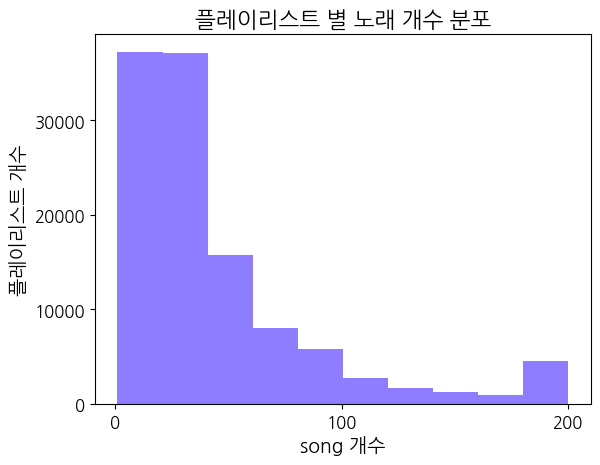

In [36]:
plt.hist(playlists['songs_cnt'], color='#8E7EFF')


plt.title("플레이리스트 별 노래 개수 분포", fontsize=16)
plt.xlabel("song 개수", fontsize=14)
plt.ylabel("플레이리스트 개수", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

- 평균, 표준편차, 신뢰구간 확인

In [39]:
# songs_cnt 열의 데이터 추출
songs_cnt_data = playlists['songs_cnt']

# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(songs_cnt_data)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(songs_cnt_data)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 45.94
표준 편차: 43.95
95.0% 신뢰 수준의 신뢰 구간: (45.68, 46.19)


- 로그로 변환해 확인

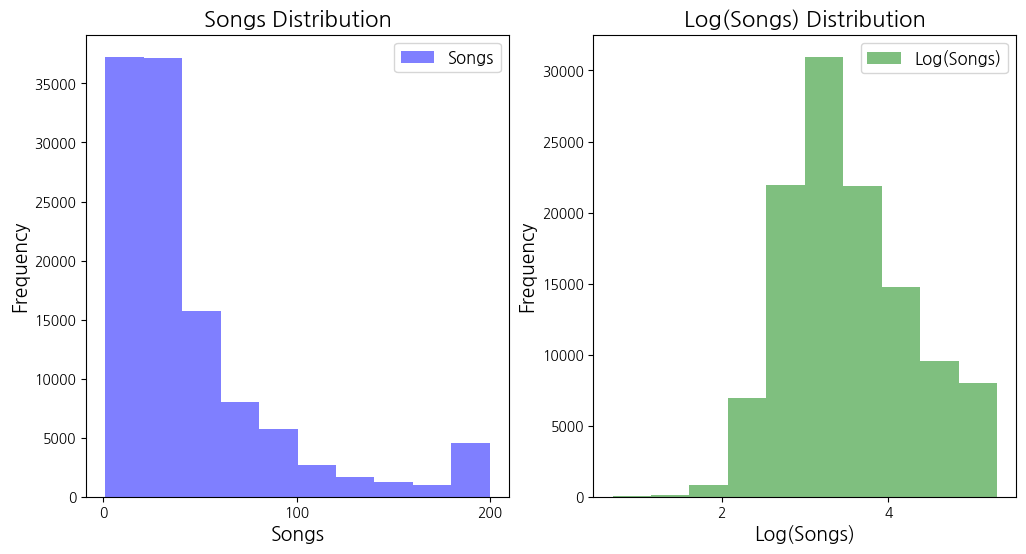

In [41]:
playlists['log_songs'] = np.log1p(playlists['songs_cnt'])  # np.log1p를 사용하여 0이하 값의 로그를 취함

# 좋아요 수의 로그 변환 결과를 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(playlists['songs_cnt'], bins=10, color='b', alpha=0.5, label='Songs')
plt.title('Songs Distribution', fontsize=16)
plt.xlabel('Songs', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(playlists['log_songs'], bins=10, color='g', alpha=0.5, label='Log(Songs)')
plt.title('Log(Songs) Distribution', fontsize=16)
plt.xlabel('Log(Songs)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

In [42]:
import scipy
scipy.stats.skew(songs_cnt_data) # 왜도 값

2.1036129520649274

- 좋아요
    - 플레이리스트 별 좋아요 분포 - boxplot

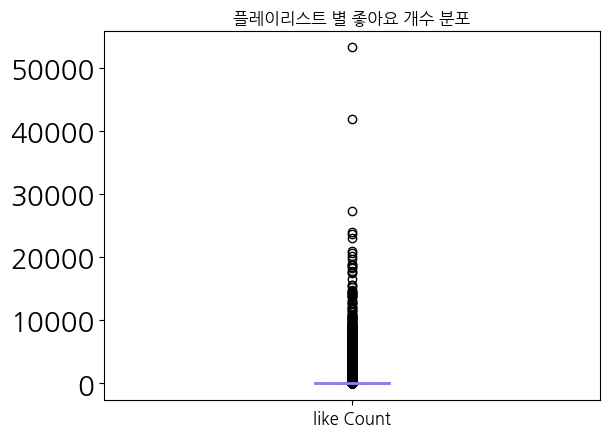

In [43]:
# 박스플롯 생성
boxplot = plt.boxplot(playlists['like_cnt'])

# 중앙값 색상 설정 (보라색)
for median in boxplot['medians']:
    median.set(color='#8E7EFF', linewidth=2)

# X 축 레이블 및 제목 설정
plt.xticks([1], ['like Count'], fontsize=12)
plt.title('플레이리스트 별 좋아요 개수 분포', fontsize=12)

plt.show()

In [156]:
playlists['like_cnt'].describe()

count    115071.000000
mean         95.197687
std         560.653757
min           0.000000
25%           2.000000
50%           7.000000
75%          24.000000
max       53211.000000
Name: like_cnt, dtype: float64

In [44]:
Q1 = 2
Q3 = 24
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-31.0
57.0


=> IQR 범위가 애매함

- 플레이리스트 별 좋아요 분포 - 히스토그램

In [158]:
# 좋아요 개수 별 차지 비율 확인인
ply_like_cnt = playlists.groupby('like_cnt').size().reset_index(name='playlist_count')
ply_like_cnt['rate'] = ply_like_cnt['playlist_count'].apply(lambda x: (x/ply_like_cnt['playlist_count'].sum())*100)
ply_like_cnt

,like_cnt,playlist_count,rate
0,0,10356,8.999661
1,1,10197,8.861486
2,2,8499,7.385875
3,3,7463,6.485561
4,4,6465,5.618270
...,...,...,...
2424,23732,1,0.000869
2425,23965,1,0.000869
2426,27268,1,0.000869
2427,41844,1,0.000869


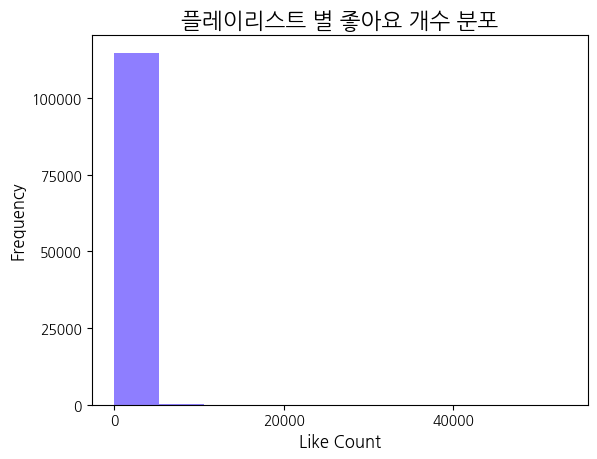

In [45]:
# 전체 Histogram
plt.hist(playlists['like_cnt'], color='#8E7EFF')

plt.title("플레이리스트 별 좋아요 개수 분포", fontsize=16)
plt.xlabel('Like Count', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.show()

- 평균, 표준편차, 신뢰구간 확인

In [46]:
# like_cnt 열의 데이터 추출
like_cnt_data = playlists['like_cnt']

# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(like_cnt_data)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(songs_cnt_data)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 95.20
표준 편차: 560.65
95.0% 신뢰 수준의 신뢰 구간: (91.96, 98.44)


- 로그로 변환해 확인

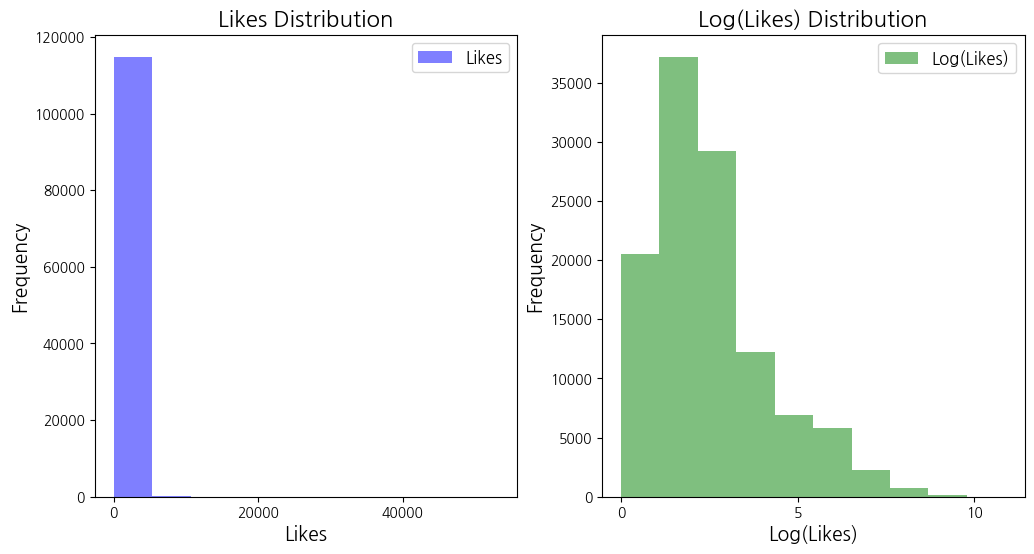

In [47]:
playlists['log_likes'] = np.log1p(playlists['like_cnt'])  # np.log1p를 사용하여 0이하 값의 로그를 취함

# 좋아요 수의 로그 변환 결과를 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(playlists['like_cnt'], bins=10, color='b', alpha=0.5, label='Likes')
plt.title('Likes Distribution', fontsize=16)
plt.xlabel('Likes', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(playlists['log_likes'], bins=10, color='g', alpha=0.5, label='Log(Likes)')
plt.title('Log(Likes) Distribution', fontsize=16)
plt.xlabel('Log(Likes)', fontsize=14)
plt.ylabel('Frequency', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

In [48]:
playlists['log_likes'].describe()

count    115071.000000
mean          2.431437
std           1.721291
min           0.000000
25%           1.098612
50%           2.079442
75%           3.218876
max          10.882039
Name: log_likes, dtype: float64

In [49]:
Q1 = 1.098612
Q3 = 3.218876
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-2.081784
6.399272


In [50]:
print(np.exp(Q1-(1.5*IQR))) # 지수 함수 계산
print(np.exp(Q3+(1.5*IQR)))

0.12470753538679492
601.4070541299369


In [51]:
Q1 = 1.098612
np.exp(Q1)
# 25% 구간 값

2.9999991339957957

=> 좋아요 수의 편차가 심하다.

> 노래, 태그 사용 빈도

- 노래
    - song 별 사용 빈도

In [53]:
ply_song_freq = playlists.explode('songs').groupby('songs').count()['id']
ply_song_freq

songs
0          2
3          8
4          2
5          5
6          1
          ..
707984     1
707985     4
707986    11
707987     1
707988     1
Name: id, Length: 615142, dtype: int64

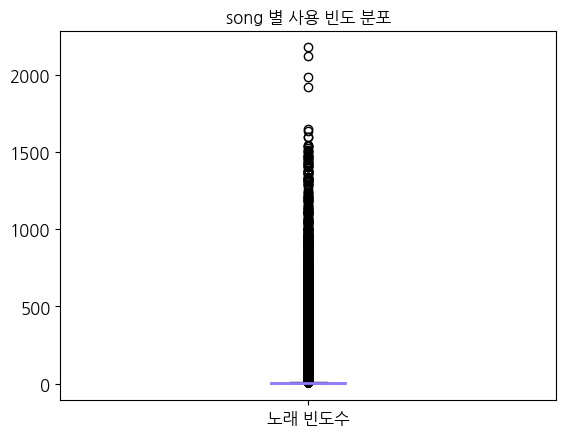

In [54]:
# song 별 사용 빈도 boxplot

boxplot = plt.boxplot(ply_song_freq)

# 중앙값 색상 설정
for median in boxplot['medians']:
     median.set(color='#8E7EFF', linewidth=2)
    
plt.xticks([1], ['노래 빈도수'], fontsize=12) 
plt.yticks(fontsize=12)
plt.title('song 별 사용 빈도 분포', fontsize=12)

plt.show()

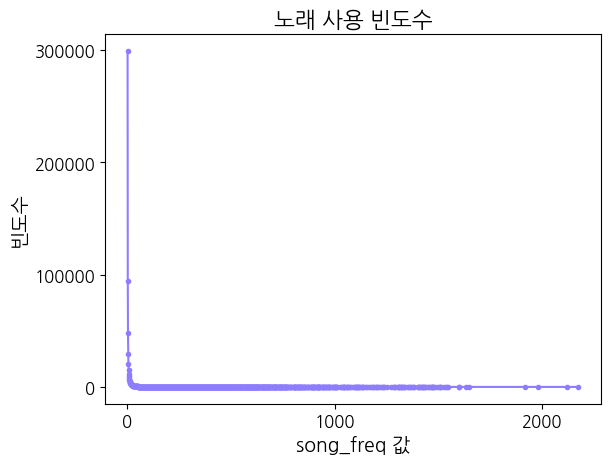

In [56]:
# 노래 사용 빈도수 선그래프

ply_song_freq_plot = pd.DataFrame(ply_song_freq).reset_index(drop=True).rename(columns={'id':'song_freq'})
ply_song_freq_plot

value_counts = ply_song_freq_plot['song_freq'].value_counts().sort_index()

x = value_counts.index  # x 축 데이터 (song_freq 값)
y = value_counts.values  # y 축 데이터 (빈도수)

plt.plot(x, y, color='#8E7EFF', marker='o', linestyle='-', markersize=3)

plt.title("노래 사용 빈도수", fontsize=16)
plt.xlabel("song_freq 값", fontsize=14)
plt.ylabel("빈도수", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [187]:
ply_song_freq.describe()

count    615142.000000
mean          8.592928
std          39.481912
min           1.000000
25%           1.000000
50%           2.000000
75%           4.000000
max        2175.000000
Name: id, dtype: float64

In [57]:
# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(ply_song_freq)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(ply_song_freq)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 8.59
표준 편차: 39.48
95.0% 신뢰 수준의 신뢰 구간: (8.49, 8.69)


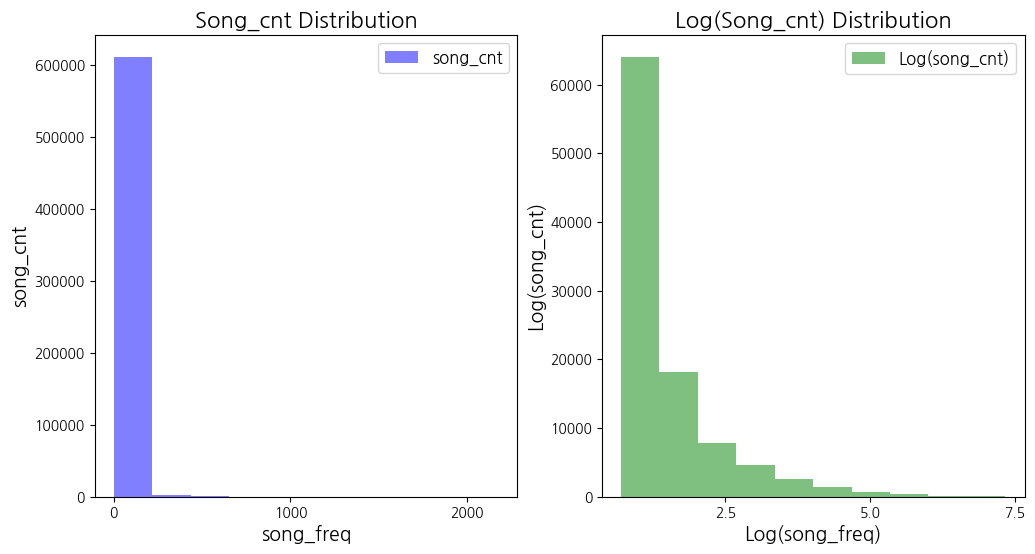

In [58]:
# 로그 변환 적용
playlists['song_freq'] = np.log1p(ply_song_freq)  # np.log1p를 사용하여 0이하 값의 로그를 취함

# 좋아요 수의 로그 변환 결과를 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ply_song_freq, bins=10, color='b', alpha=0.5, label='song_cnt')
plt.title('Song_cnt Distribution', fontsize=16)
plt.xlabel('song_freq', fontsize=14)
plt.ylabel('song_cnt', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(playlists['song_freq'], bins=10, color='g', alpha=0.5, label='Log(song_cnt)')
plt.title('Log(Song_cnt) Distribution', fontsize=16)
plt.xlabel('Log(song_freq)', fontsize=14)
plt.ylabel('Log(song_cnt)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

In [62]:
# 노래 별 사용빈도 비율 확인

ply_song_freq_cnt = ply_song_freq.reset_index().groupby('id').count()['songs'].reset_index().rename(columns={'id':'freq', 'songs':'songs_cnt'})
ply_song_freq_cnt['songs_cnt_rate'] = ply_song_freq_cnt['songs_cnt'].apply(lambda x: x /ply_song_freq_cnt['songs_cnt'].sum()*100)
ply_song_freq_cnt['song_rate'] =ply_song_freq_cnt['freq'].apply(lambda x: x /ply_song_freq_cnt['freq'].sum()*100)
ply_song_freq_cnt

,freq,songs_cnt,songs_cnt_rate,song_rate
0,1,299028,48.611215,0.000192
1,2,94458,15.355479,0.000385
2,3,47587,7.735937,0.000577
3,4,29395,4.778571,0.000769
4,5,20048,3.259085,0.000961
...,...,...,...,...
952,1647,1,0.000163,0.316660
953,1919,1,0.000163,0.368955
954,1981,1,0.000163,0.380876
955,2121,1,0.000163,0.407793


In [63]:
# 1~5번 사용된 노래 비율 확인
ply_song_freq_cnt.head(5)['songs_cnt_rate'].sum()

79.74028760838961

In [61]:
# 많이 사용된 노래 top30 비율 확인인
ply_song_freq_cnt.tail(30)['song_rate'].sum()

9.09276182089799

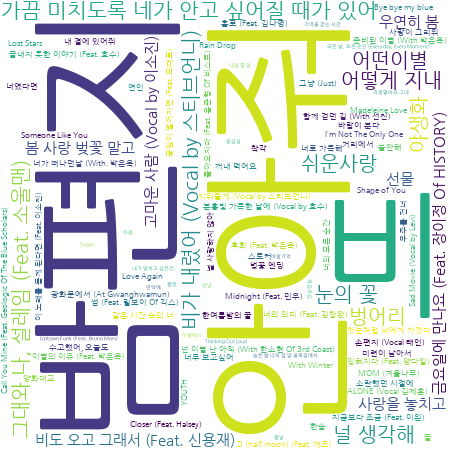

In [64]:
# 빈도수 높은 노래 워드클라우드

from wordcloud import WordCloud
plylst_song_map = playlists[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

# 태그 별 매핑 빈도 수 저장 
song_cnt = plylst_song_map.groupby('songs').songs.count().reset_index(name = 'mapping_cnt')
song_cnt['songs'] = song_cnt['songs'].astype(str)
song_cnt['mapping_cnt'] = song_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
song_cnt = song_cnt[song_cnt['mapping_cnt'] >= 1000]
song_meta_tmp = song_meta[['song_name', 'id']]
song_cnt['songs'] = song_cnt['songs'].astype(int)

# 두 DataFrame을 'songs' 열과 'id' 열을 기준으로 병합
song_cnt_merged = pd.merge(song_cnt, song_meta_tmp, left_on='songs', right_on='id', how='left')

word_count = list(zip(song_cnt_merged['song_name'], song_cnt_merged['mapping_cnt']))

# plotting
wc = WordCloud(font_path = './font/NanumGothic.ttf', background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 노래 빈도수와 좋아요 상관관계 확인

In [82]:
# 노래 별 좋아요 수 확인
ply_song_like = playlists.explode('songs').groupby('songs').sum()['like_cnt']
ply_song_like = pd.DataFrame(ply_song_like).reset_index()
ply_song_like

C:\Users\cg063\AppData\Local\Temp\ipykernel_16772\3770578481.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ply_song_like = playlists.explode('songs').groupby('songs').sum()['like_cnt']


,songs,like_cnt
0,0,29
1,3,1686
2,4,39
3,5,391
4,6,24
...,...,...
615137,707984,2
615138,707985,11
615139,707986,1123
615140,707987,4


In [83]:
# 노래 사용 빈도수 확인
ply_song_freq = playlists.explode('songs').groupby('songs').count()['id']
ply_song_freq = pd.DataFrame(ply_song_freq).reset_index()
ply_song_freq.rename(columns={'id':'freq'}, inplace=True)
ply_song_freq

,songs,freq
0,0,2
1,3,8
2,4,2
3,5,5
4,6,1
...,...,...
615137,707984,1
615138,707985,4
615139,707986,11
615140,707987,1


In [84]:
# 상관관계 확인을 위한 데이터프레임 형성
ply_corr_song = pd.merge(ply_song_like, ply_song_freq, how='left', on='songs')
ply_corr_song.describe()

,songs,like_cnt,freq
count,615142.000000,615142.000000,615142.000000
mean,353955.493888,1508.641172,8.592928
std,204338.932425,6652.869225,39.481912
min,0.000000,0.000000,1.000000
25%,176957.250000,13.000000,1.000000
50%,353982.500000,76.000000,2.000000
75%,530864.750000,563.000000,4.000000
max,707988.000000,326947.000000,2175.000000


In [85]:
ply_corr_song.corr()

,songs,like_cnt,freq
songs,1.000000,0.000023,0.000196
like_cnt,0.000023,1.000000,0.801743
freq,0.000196,0.801743,1.000000


In [87]:
# ply_corr_song DataFrame의 'column_name' 열의 80% 백분위수 확인
percentile_80 = np.percentile(ply_corr_song['freq'], 80)

print(percentile_80)

6.0


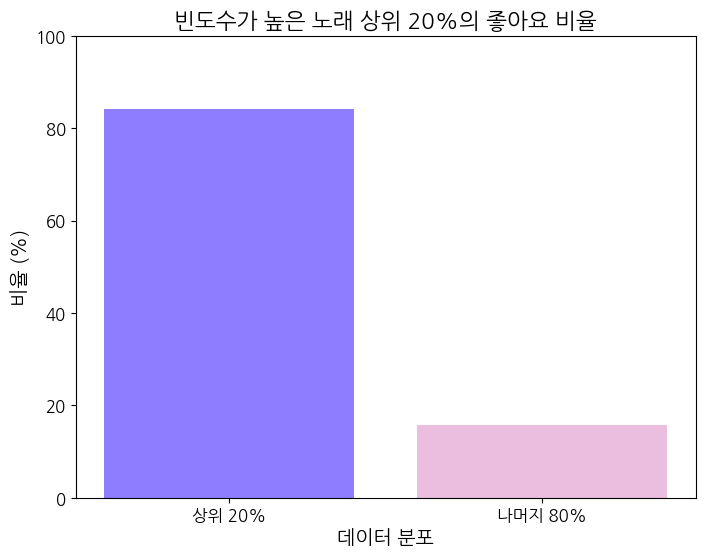

In [97]:
# 데이터프레임을 'freq' 열을 기준으로 내림차순 정렬
sorted_df = ply_corr_song.sort_values(by='freq', ascending=False)

# 상위 20%의 노래 선택
top_20_percent = sorted_df.head(int(0.2 * len(sorted_df)))

# 상위 20% 노래의 'like_cnt' 합계 계산
like_cnt_top_20_percent = top_20_percent['like_cnt'].sum()

# 전체 'like_cnt'의 합계 계산
total_like_cnt = ply_corr_song['like_cnt'].sum()

# 상위 20% 노래의 'like_cnt'가 전체 'like_cnt'에서 차지하는 비율 계산
percentage = (like_cnt_top_20_percent / total_like_cnt) * 100

# 결과 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
plt.bar(['상위 20%', '나머지 80%'], [percentage, 100 - percentage], color=['#8E7EFF', '#EBBEDF'])
plt.title("빈도수가 높은 노래 상위 20%의 좋아요 비율", fontsize=16)
plt.xlabel("데이터 분포", fontsize=14)
plt.ylabel("비율 (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # y축 범위 설정

plt.show()

In [105]:
# 데이터프레임을 'freq' 열을 기준으로 내림차순 정렬
sorted_df = ply_corr_song.sort_values(by='freq', ascending=False)

# 상위 20%의 노래 선택
top_20_percent = sorted_df.head(int(0.2 * len(sorted_df)))

# 상위 20% 노래의 'like_cnt' 합계 계산
like_cnt_top_20_percent = top_20_percent['like_cnt'].sum()

# 전체 'like_cnt'의 합계 계산
total_like_cnt = ply_corr_song['like_cnt'].sum()

# 상위 20% 노래의 'like_cnt'가 전체 'like_cnt'에서 차지하는 비율 계산
percentage = (like_cnt_top_20_percent / total_like_cnt) * 100

print(f"빈도수가 높은 노래 상위 20%가 전체 좋아요의 {percentage:.2f}%를 차지합니다.")

빈도수가 높은 노래 상위 20%가 전체 좋아요의 84.18%를 차지합니다.


=> 빈도수 기준 상위 20% 사용

- 태그
    - 태그 별 사용 빈도

In [65]:
playlists.explode('tags').groupby('tags').count()['id'].describe()

count    29160.000000
mean        16.335082
std        247.011075
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      16465.000000
Name: id, dtype: float64

In [66]:
Q1 = 1
Q3 = 3
IQR = Q3 - Q1

print(Q1-(1.5*IQR))
print(Q3+(1.5*IQR))

-2.0
6.0


In [67]:
ply_tag_freq = playlists.explode('tags').groupby('tags').count()['id']
ply_tag_freq

tags
          1
00        4
007       3
007시리즈    2
00s       3
         ..
힙해        5
힙힙힙       2
힛뎀포크      1
힛뎀폭       1
힛뎀폭스      2
Name: id, Length: 29160, dtype: int64

Text(0.5, 1.0, '태그 별 사용 빈도 분포')

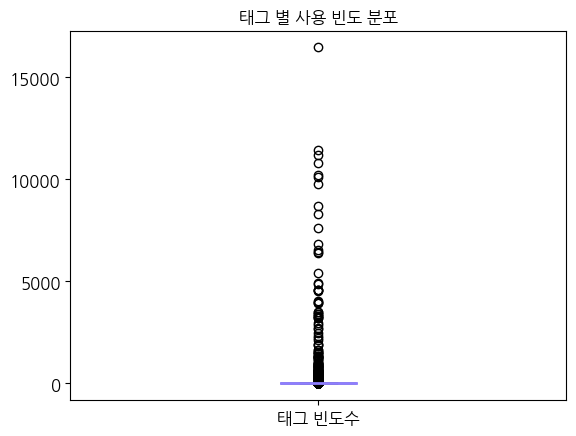

In [69]:
# 플리 별 태그 개수 분포

boxplot = plt.boxplot(ply_tag_freq)

# 중앙값 색상 설정
for median in boxplot['medians']:
     median.set(color='#8E7EFF', linewidth=2)
     
plt.xticks([1], ['태그 빈도수'], fontsize=12) 
plt.yticks(fontsize=12)
plt.title('태그 별 사용 빈도 분포', fontsize=12)

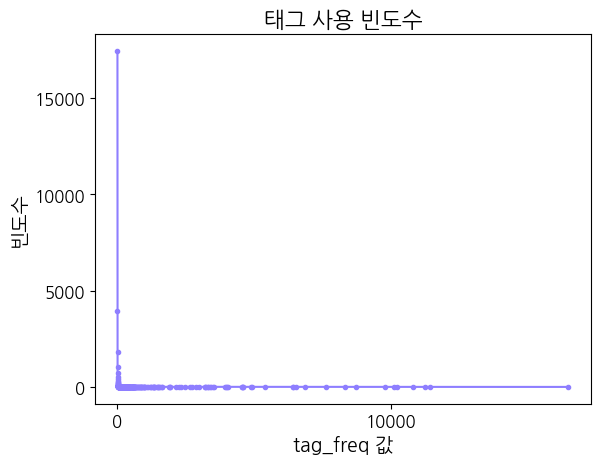

In [70]:
ply_tag_freq_plot = pd.DataFrame(ply_tag_freq).reset_index(drop=True).rename(columns={'id':'tag_freq'})
ply_tag_freq_plot

value_counts = ply_tag_freq_plot['tag_freq'].value_counts().sort_index()

x = value_counts.index  
y = value_counts.values 

plt.plot(x, y, color='#8E7EFF', marker='o', linestyle='-', markersize=3)

plt.title("태그 사용 빈도수", fontsize=16)
plt.xlabel("tag_freq 값", fontsize=14)
plt.ylabel("빈도수", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.show()

In [71]:
ply_tag_freq.describe()

count    29160.000000
mean        16.335082
std        247.011075
min          1.000000
25%          1.000000
50%          1.000000
75%          3.000000
max      16465.000000
Name: id, dtype: float64

In [72]:
# 정규분포의 평균과 표준 편차 추정
mean, std_dev = stats.norm.fit(ply_tag_freq)

# 신뢰 수준 (일반적으로 95%)에 해당하는 신뢰 구간 계산
confidence_level = 0.95
alpha = 1 - confidence_level
z_score = stats.norm.ppf(1 - alpha / 2)  # 신뢰 수준에 해당하는 Z-점수 계산
margin_of_error = z_score * (std_dev / np.sqrt(len(ply_tag_freq)))
confidence_interval = (mean - margin_of_error, mean + margin_of_error)

# 정규분포의 범위 확인
print(f"평균: {mean:.2f}")
print(f"표준 편차: {std_dev:.2f}")
print(f"{confidence_level*100}% 신뢰 수준의 신뢰 구간: ({confidence_interval[0]:.2f}, {confidence_interval[1]:.2f})")

평균: 16.34
표준 편차: 247.01
95.0% 신뢰 수준의 신뢰 구간: (13.50, 19.17)


c:\Users\cg063\AppData\Local\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Glyph 8722 (\N{MINUS SIGN}) missing from current font.
  fig.canvas.print_figure(bytes_io, **kw)


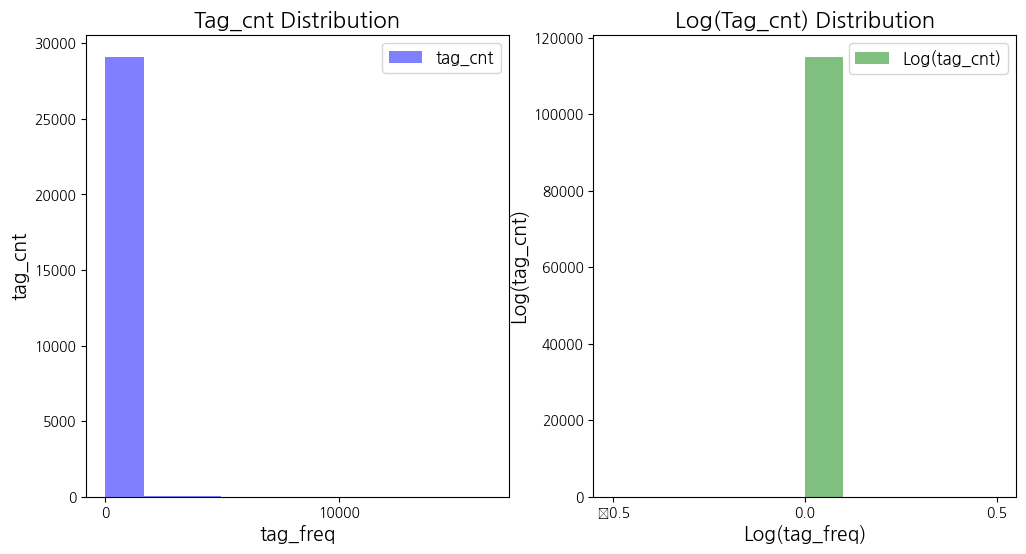

In [74]:
# 로그 변환 적용
playlists['tag_freq'] = np.log1p(ply_tag_freq)  # np.log1p를 사용하여 0이하 값의 로그를 취함

playlists['tag_freq'].fillna(0, inplace=True)
# 무한대 값을 NaN으로 대체
playlists['tag_freq'].replace([np.inf, -np.inf], np.nan, inplace=True)
# 로그 변환
playlists['tag_freq'] = np.log1p(playlists['tag_freq'])

# 좋아요 수의 로그 변환 결과를 시각화
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.hist(ply_tag_freq, bins=10, color='b', alpha=0.5, label='tag_cnt')
plt.title('Tag_cnt Distribution', fontsize=16)
plt.xlabel('tag_freq', fontsize=14)
plt.ylabel('tag_cnt', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.subplot(1, 2, 2)
plt.hist(playlists['tag_freq'], bins=10, color='g', alpha=0.5, label='Log(tag_cnt)')
plt.title('Log(Tag_cnt) Distribution', fontsize=16)
plt.xlabel('Log(tag_freq)', fontsize=14)
plt.ylabel('Log(tag_cnt)', fontsize=14)
plt.xticks(fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12)

plt.show()

In [75]:
# 태그 별 사용빈도 비율 확인

ply_tag_freq_cnt = ply_tag_freq.reset_index().groupby('id').count()['tags'].reset_index().rename(columns={'id':'freq', 'tags':'tags_cnt'})
ply_tag_freq_cnt['tags_cnt_rate'] = ply_tag_freq_cnt['tags_cnt'].apply(lambda x: x /ply_tag_freq_cnt['tags_cnt'].sum()*100)
ply_tag_freq_cnt['freq_rate'] =ply_tag_freq_cnt['freq'].apply(lambda x: x /ply_tag_freq_cnt['freq'].sum()*100)
ply_tag_freq_cnt

,freq,tags_cnt,tags_cnt_rate,freq_rate
0,1,17431,59.777092,0.000292
1,2,3944,13.525377,0.000584
2,3,1803,6.183128,0.000876
3,4,1053,3.611111,0.001168
4,5,704,2.414266,0.001460
...,...,...,...,...
388,10218,1,0.003429,2.984647
389,10796,1,0.003429,3.153479
390,11215,1,0.003429,3.275868
391,11417,1,0.003429,3.334872


In [76]:
# 1~5번 사용된 태그 비율 확인
ply_tag_freq_cnt.head(5)['tags_cnt_rate'].sum()

85.51097393689986

In [80]:
# 많이 사용된 태그 top10 비율 확인
ply_tag_freq_cnt.tail(10)['freq_rate'].sum()

30.561527316913583

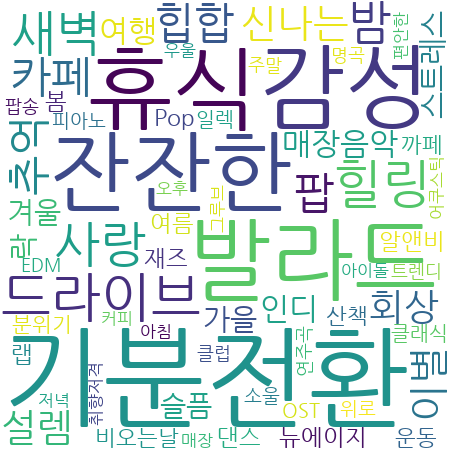

In [81]:
# 빈도수 높은 태그 워드클라우드

plylst_tag_map = playlists[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

# 태그 별 매핑 빈도 수 저장 
tag_cnt = plylst_tag_map.groupby('tags').tags.count().reset_index(name = 'mapping_cnt')
tag_cnt['tags'] = tag_cnt['tags'].astype(str)
tag_cnt['mapping_cnt'] = tag_cnt['mapping_cnt'].astype(int)

# 빈도 수가 1000회 이상인 태그만 저장
tag_cnt = tag_cnt[tag_cnt['mapping_cnt'] >= 1000]
word_count = list(zip(tag_cnt['tags'], tag_cnt['mapping_cnt']))

# plotting
wc = WordCloud(font_path = './font/NanumGothic.ttf', background_color = 'white', max_words = 100, width = 450, height = 450)
wc.generate_from_frequencies(dict(word_count)).to_image()

- 태그 빈도수와 좋아요 상관관계

In [98]:
# 태그 별 좋아요 수 확인
ply_tag_like = playlists.explode('tags').groupby('tags').sum()['like_cnt']
ply_tag_like = pd.DataFrame(ply_tag_like).reset_index()
ply_tag_like

C:\Users\cg063\AppData\Local\Temp\ipykernel_16772\2521299836.py:2: FutureWarning: The default value of numeric_only in DataFrameGroupBy.sum is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  ply_tag_like = playlists.explode('tags').groupby('tags').sum()['like_cnt']


,tags,like_cnt
0,,7
1,00,160
2,007,144
3,007시리즈,65
4,00s,25
...,...,...
29155,힙해,2367
29156,힙힙힙,19
29157,힛뎀포크,41
29158,힛뎀폭,41


In [99]:
# 태그 사용 빈도수 확인
ply_tag_freq = playlists.explode('tags').groupby('tags').count()['id']
ply_tag_freq = pd.DataFrame(ply_tag_freq).reset_index()
ply_tag_freq.rename(columns={'id':'freq'}, inplace=True)
ply_tag_freq

,tags,freq
0,,1
1,00,4
2,007,3
3,007시리즈,2
4,00s,3
...,...,...
29155,힙해,5
29156,힙힙힙,2
29157,힛뎀포크,1
29158,힛뎀폭,1


In [100]:
ply_corr_tag = pd.merge(ply_tag_like, ply_tag_freq, how='left', on='tags')
ply_corr_tag

,tags,like_cnt,freq
0,,7,1
1,00,160,4
2,007,144,3
3,007시리즈,65,2
4,00s,25,3
...,...,...,...
29155,힙해,2367,5
29156,힙힙힙,19,2
29157,힛뎀포크,41,1
29158,힛뎀폭,41,1


In [101]:
# ply_corr_tag DataFrame의 'column_name' 열의 80% 백분위수 확인
percentile_80 = np.percentile(ply_corr_tag['freq'], 80)

print(percentile_80)

4.0


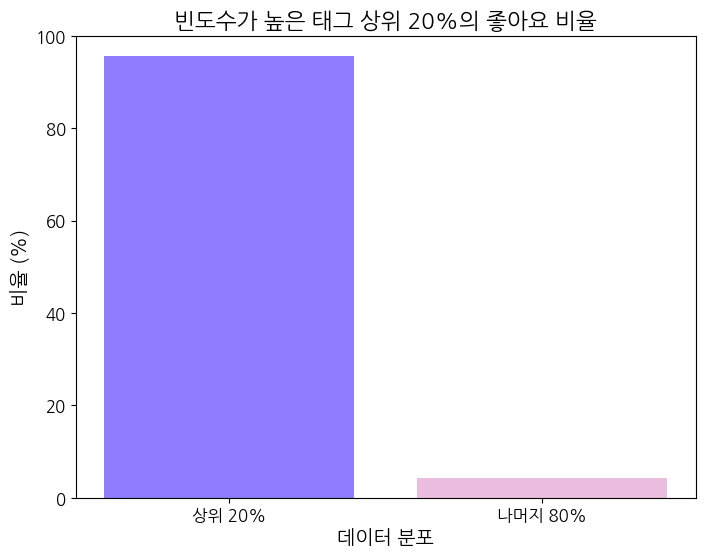

In [103]:
# 데이터프레임을 'freq' 열을 기준으로 내림차순 정렬
sorted_df = ply_corr_tag.sort_values(by='freq', ascending=False)

# 상위 20%의 노래 선택
top_20_percent = sorted_df.head(int(0.2 * len(sorted_df)))

# 상위 20% 노래의 'like_cnt' 합계 계산
like_cnt_top_20_percent = top_20_percent['like_cnt'].sum()

# 전체 'like_cnt'의 합계 계산
total_like_cnt = ply_corr_tag['like_cnt'].sum()

# 상위 20% 노래의 'like_cnt'가 전체 'like_cnt'에서 차지하는 비율 계산
percentage = (like_cnt_top_20_percent / total_like_cnt) * 100

# 결과 시각화
plt.figure(figsize=(8, 6))  # 그래프 크기 설정
plt.bar(['상위 20%', '나머지 80%'], [percentage, 100 - percentage], color=['#8E7EFF', '#EBBEDF'])
plt.title("빈도수가 높은 태그 상위 20%의 좋아요 비율", fontsize=16)
plt.xlabel("데이터 분포", fontsize=14)
plt.ylabel("비율 (%)", fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
plt.ylim(0, 100)  # y축 범위 설정

plt.show()

In [106]:
# 데이터프레임을 'freq' 열을 기준으로 내림차순 정렬
sorted_df = ply_corr_tag.sort_values(by='freq', ascending=False)

# 상위 20%의 노래 선택
top_20_percent = sorted_df.head(int(0.2 * len(sorted_df)))

# 상위 20% 노래의 'like_cnt' 합계 계산
like_cnt_top_20_percent = top_20_percent['like_cnt'].sum()

# 전체 'like_cnt'의 합계 계산
total_like_cnt = ply_corr_tag['like_cnt'].sum()

# 상위 20% 노래의 'like_cnt'가 전체 'like_cnt'에서 차지하는 비율 계산
percentage = (like_cnt_top_20_percent / total_like_cnt) * 100

print(f"빈도수가 높은 태그 상위 20%가 전체 좋아요의 {percentage:.2f}%를 차지합니다.")

빈도수가 높은 태그 상위 20%가 전체 좋아요의 95.69%를 차지합니다.


=> 50% 미만 빼기(원래 아이디어)  
=> 통계적으로 확인이 아예 불가능한듯. 왜냐하면 평균, 표준편차가 수염범위에 안들어옴

- 태그 별 매핑 장르 확인

### step1. 플레이리스트 태그 별 어떤 곡들이 수록되어 있을까?

In [128]:
# 플레이리스트 아이디(id)와 수록곡(songs) 추출
plylst_song_map = playlists[['id', 'songs']]

# unnest songs
plylst_song_map_unnest = np.dstack(
    (
        np.repeat(plylst_song_map.id.values, list(map(len, plylst_song_map.songs))), 
        np.concatenate(plylst_song_map.songs.values)
    )
)

# unnested 데이터프레임 생성 : plylst_song_map
plylst_song_map = pd.DataFrame(data = plylst_song_map_unnest[0], columns = plylst_song_map.columns)
plylst_song_map['id'] = plylst_song_map['id'].astype(str)
plylst_song_map['songs'] = plylst_song_map['songs'].astype(str)

# unnest 객체 제거
del plylst_song_map_unnest

# ===================================================================================================

# 플레이리스트 아이디(id)와 매핑된 태그(tags) 추출
plylst_tag_map = playlists[['id', 'tags']]

# unnest tags
plylst_tag_map_unnest = np.dstack(
    (
        np.repeat(plylst_tag_map.id.values, list(map(len, plylst_tag_map.tags))), 
        np.concatenate(plylst_tag_map.tags.values)
    )
)

# unnested 데이터프레임 생성 : plylst_tag_map
plylst_tag_map = pd.DataFrame(data = plylst_tag_map_unnest[0], columns = plylst_tag_map.columns)
plylst_tag_map['id'] = plylst_tag_map['id'].astype(str)

# unnest 객체 제거
del plylst_tag_map_unnest

# ===================================================================================================

# 곡 아이디(id)와 대분류 장르코드 리스트(song_gn_gnr_basket) 추출
song_gnr_map = song_meta.loc[:, ['id', 'song_gn_gnr_basket']]

# unnest song_gn_gnr_basket
song_gnr_map_unnest = np.dstack(
    (
        np.repeat(song_gnr_map.id.values, list(map(len, song_gnr_map.song_gn_gnr_basket))), 
        np.concatenate(song_gnr_map.song_gn_gnr_basket.values)
    )
)

# unnested 데이터프레임 생성 : song_gnr_map
song_gnr_map = pd.DataFrame(data = song_gnr_map_unnest[0], columns = song_gnr_map.columns)
song_gnr_map['id'] = song_gnr_map['id'].astype(str)
song_gnr_map.rename(columns = {'id' : 'song_id', 'song_gn_gnr_basket' : 'gnr_code'}, inplace = True)

# unnest 객체 제거
del song_gnr_map_unnest

In [129]:
# 장르코드 뒷자리 두 자리가 00인 코드를 필터링
gnr_code = genre_gn_all[genre_gn_all['gnr_code'].str[-2:] == '00']
gnr_code = gnr_code.assign(join_code = gnr_code['gnr_code'].str[0:4])

In [130]:
plylst_song_tag_map = pd.merge(plylst_song_map, plylst_tag_map, how = 'left', on = 'id')

# 2. 1번 테이블 plylst_song_tag_map + 곡 장르 테이블 song_gnr_map join
plylst_song_tag_map = pd.merge(plylst_song_tag_map, song_gnr_map, how = 'left', left_on = 'songs', right_on = 'song_id')

# 3. 2번 테이블에서 장르 메타 join
gnr_code['gnr_code_name'] = gnr_code['gnr_code'] + ' (' + gnr_code['gnr_name'] + ')'
gnr_code = gnr_code[['gnr_code', 'gnr_code_name']]
plylst_song_tag_map = pd.merge(plylst_song_tag_map, gnr_code, how = 'left', on = 'gnr_code')

# 4. 최종 테이블 필드 선택
plylst_song_tag_map = plylst_song_tag_map[['id', 'songs', 'tags', 'gnr_code_name']]

In [131]:
# 태그 = ['드라이브', '스트레스', '기분전환']
song_tag_map_sample_1 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['드라이브', '스트레스', '기분전환']), :]
# 태그 = ['밤', '새벽', '잔잔한']
song_tag_map_sample_2 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['밤', '새벽', '잔잔한']), :]
# 태그 = ['사랑', '설렘']
song_tag_map_sample_3 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['사랑', '설렘']), :]
# 태그 = ['추억', '회상']
song_tag_map_sample_4 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['추억', '회상']), :]
# 태그 = ['슬픔', '이별']
song_tag_map_sample_5 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['슬픔', '이별']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_6 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['휴식', '힐링']), :]
# 태그 = ['휴식', '힐링']
song_tag_map_sample_7 = plylst_song_tag_map.loc[plylst_song_tag_map.tags.isin(['카페', '매장음악']), :]

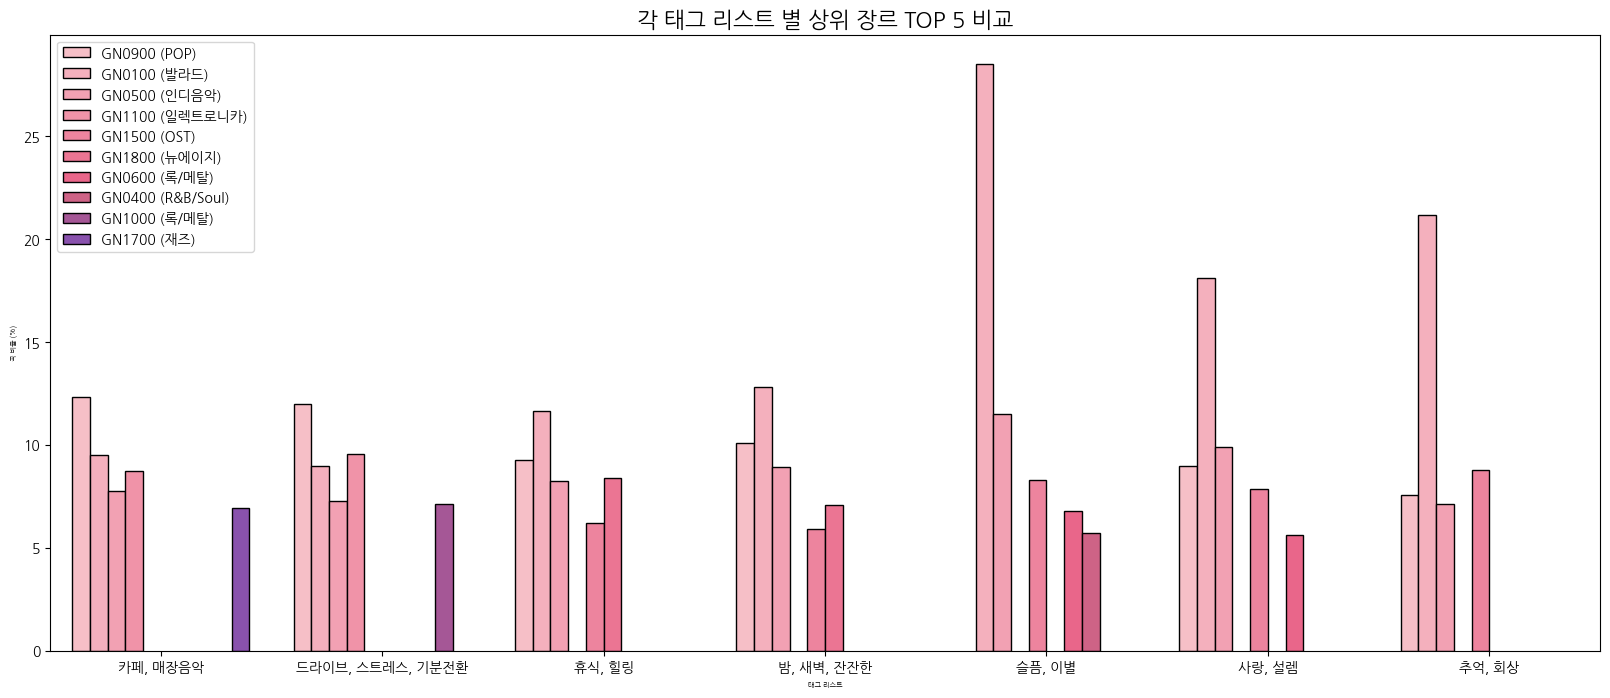

In [132]:
# 각 샘플 태그 리스트 별 장르 비율 집계
song_tag_map_sample_1_gnr_rank = song_tag_map_sample_1.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_1_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_1_gnr_rank['song_cnt']/sum(song_tag_map_sample_1_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_1_gnr_rank['gnr_rank'] = song_tag_map_sample_1_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_1_gnr_rank['tag_list'] = '드라이브, 스트레스, 기분전환'
song_tag_map_sample_1_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_2_gnr_rank = song_tag_map_sample_2.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_2_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_2_gnr_rank['song_cnt']/sum(song_tag_map_sample_2_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_2_gnr_rank['gnr_rank'] = song_tag_map_sample_2_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_2_gnr_rank['tag_list'] = '밤, 새벽, 잔잔한'
song_tag_map_sample_2_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_3_gnr_rank = song_tag_map_sample_3.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_3_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_3_gnr_rank['song_cnt']/sum(song_tag_map_sample_3_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_3_gnr_rank['gnr_rank'] = song_tag_map_sample_3_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_3_gnr_rank['tag_list'] = '사랑, 설렘'
song_tag_map_sample_3_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_4_gnr_rank = song_tag_map_sample_4.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_4_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_4_gnr_rank['song_cnt']/sum(song_tag_map_sample_4_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_4_gnr_rank['gnr_rank'] = song_tag_map_sample_4_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_4_gnr_rank['tag_list'] = '추억, 회상'
song_tag_map_sample_4_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_5_gnr_rank = song_tag_map_sample_5.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_5_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_5_gnr_rank['song_cnt']/sum(song_tag_map_sample_5_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_5_gnr_rank['gnr_rank'] = song_tag_map_sample_5_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_5_gnr_rank['tag_list'] = '슬픔, 이별'
song_tag_map_sample_5_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_6_gnr_rank = song_tag_map_sample_6.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_6_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_6_gnr_rank['song_cnt']/sum(song_tag_map_sample_6_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_6_gnr_rank['gnr_rank'] = song_tag_map_sample_6_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_6_gnr_rank['tag_list'] = '휴식, 힐링'
song_tag_map_sample_6_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

song_tag_map_sample_7_gnr_rank = song_tag_map_sample_7.groupby('gnr_code_name').songs.nunique().reset_index(name = 'song_cnt')
song_tag_map_sample_7_gnr_rank.loc[:, 'song_cnt_ratio'] = round(song_tag_map_sample_7_gnr_rank['song_cnt']/sum(song_tag_map_sample_7_gnr_rank['song_cnt'])*100, 2)
song_tag_map_sample_7_gnr_rank['gnr_rank'] = song_tag_map_sample_7_gnr_rank['song_cnt_ratio'].rank(ascending = False)
song_tag_map_sample_7_gnr_rank['tag_list'] = '카페, 매장음악'
song_tag_map_sample_7_gnr_rank.rename(columns = {'gnr_code_name' : '장르', 'song_cnt' : '곡 수', 'song_cnt_ratio' : '비율(%)', 'gnr_rank' : '순위', 'tag_list' : '태그 리스트'}, inplace = True)

# delete object
del song_tag_map_sample_1, song_tag_map_sample_2, song_tag_map_sample_3, song_tag_map_sample_4, song_tag_map_sample_5, song_tag_map_sample_6, song_tag_map_sample_7

# row binding
song_tag_map_sample_rbind = pd.concat(
    [song_tag_map_sample_1_gnr_rank, song_tag_map_sample_2_gnr_rank, song_tag_map_sample_3_gnr_rank,
     song_tag_map_sample_4_gnr_rank, song_tag_map_sample_5_gnr_rank, song_tag_map_sample_6_gnr_rank,
     song_tag_map_sample_7_gnr_rank],
    axis = 0
)

# plotting

# 원하는 색상 코드
custom_palette = ['#FFB6C1', '#FFA5B6', '#FF94AB', '#FF83A0', '#FF7295', '#FF618A', '#FF5080', '#E05180', '#B24A9E', '#8C43BC']

plt.figure(figsize=(20, 8))

song_tag_map_sample_rbind_plot = sns.barplot(
    data=song_tag_map_sample_rbind.loc[song_tag_map_sample_rbind['순위'] <= 5, :].sort_values(by='순위'),
    x='태그 리스트', y='비율(%)', hue='장르', edgecolor="black",
    palette=custom_palette  # 원하는 색상 팔레트 지정
)
song_tag_map_sample_rbind_plot.set_title('각 태그 리스트 별 상위 장르 TOP 5 비교', fontsize=16)
song_tag_map_sample_rbind_plot.set_xlabel('태그 리스트', fontsize=5)
song_tag_map_sample_rbind_plot.set_ylabel('곡 비율 (%)', fontsize=5)
song_tag_map_sample_rbind_plot.legend(fontsize=10)

plt.xticks(fontsize=10)
plt.show()

### step2. 태그 

In [47]:
playlists_songs = playlists.explode('songs') # song 기준으로 분해
song_meta_gnr = song_meta.explode('song_gn_gnr_basket') # 대분류 장르 기준으로 분해
ply_tag_song_gnr = pd.merge(playlists_songs, song_meta_gnr, how='left', left_on='songs', right_on='id') # 플레이리스트에 사용된 song 각각에 대분류 장르 달아주기
ply_tag_song_gnr = ply_tag_song_gnr.explode('tags') # 태그 기준으로 분해

ply_tag_gnr = ply_tag_song_gnr[['tags', 'song_gn_gnr_basket']] # 필요한 부분만 남기기

In [48]:
ply_tag_gnr.drop_duplicates(inplace=True) # 중복 행 제거

big_gnr_code = gnr_code_tree[['gnr_code', 'gnr_name']].drop_duplicates() # 대분류 장르코드, 장르 이름 가져오기

C:\Users\cg063\AppData\Local\Temp\ipykernel_4088\3607737618.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  ply_tag_gnr.drop_duplicates(inplace=True) # 중복 행 제거


In [49]:
ply_tag_gnr = pd.merge(ply_tag_gnr, big_gnr_code, how='left', left_on='song_gn_gnr_basket', right_on='gnr_code') # 대분류 코드 장르 기준으로 join해서 장르 이름 달아주기
ply_tag_gnr = ply_tag_gnr[['tags', 'gnr_code', 'gnr_name']] # 필요한 부분만 남기기
ply_tag_gnr

,tags,gnr_code,gnr_name
0,락,GN1400,포크/블루스/컨트리
1,락,GN0900,POP
2,락,GN1000,록/메탈
3,락,GN1300,R&B/Soul
4,락,GN1900,J-POP
...,...,...,...
264515,부들부들,GN0400,R&B/Soul
264516,extreme,GN1100,일렉트로니카
264517,담시,GN1500,OST
264518,퇴근버스,GN1200,랩/힙합


In [50]:
ply_tag_gnr_code_lst = ply_tag_gnr.groupby('tags')['gnr_code'].apply(list).reset_index() # 태그별 사용된 장르코드 list로 모아놓기
ply_tag_gnr_name_lst = ply_tag_gnr.groupby('tags')['gnr_name'].apply(list).reset_index() # 태그별 사용된 장르이름 list로 모아놓기
ply_tag_gnr_lst = pd.merge(ply_tag_gnr_code_lst, ply_tag_gnr_name_lst, on='tags')
ply_tag_gnr_lst

,tags,gnr_code,gnr_name
0,,"[GN1200, GN1300]","[랩/힙합, R&B/Soul]"
1,00,"[GN0900, GN1300, GN1200, GN2700, GN1100, GN150...","[POP, R&B/Soul, 랩/힙합, EDM, 일렉트로니카, OST, 록/메탈, ..."
2,007,"[GN0900, GN1500, GN1000, GN1300, GN2000, GN1700]","[POP, OST, 록/메탈, R&B/Soul, 월드뮤직, 재즈]"
3,007시리즈,"[GN0900, GN1500, GN1000, GN1300]","[POP, OST, 록/메탈, R&B/Soul]"
4,00s,"[GN0100, GN1500, GN0300, GN0400, GN0600, GN260...","[발라드, OST, 랩/힙합, R&B/Soul, 록/메탈, 일렉트로니카, 아이돌, ..."
...,...,...,...
29155,힙해,"[GN0400, GN2600, GN0500, GN0300, GN2500, GN020...","[R&B/Soul, 일렉트로니카, 인디음악, 랩/힙합, 아이돌, 댄스, 록/메탈, ..."
29156,힙힙힙,"[GN1100, GN0500, GN0400, GN0900, GN2500, GN030...","[일렉트로니카, 인디음악, R&B/Soul, POP, 아이돌, 랩/힙합, 일렉트로니..."
29157,힛뎀포크,"[GN1200, GN1300, GN1500]","[랩/힙합, R&B/Soul, OST]"
29158,힛뎀폭,"[GN1200, GN1300, GN1500]","[랩/힙합, R&B/Soul, OST]"


=> 플레이리스트 수록곡의 장르를 통해 태그 별 어떤 장르와 매핑되었는지 확인 할 수 있음

> genre_all

- 대분류 코드 중 일부 중복 :R&B/Soul(GN0400, GN1300), 록/메탈(GN0600, GN1000)  
- 대분류 코드 중 크리스마스(GN3000)는 소분류 코드 X

> song_meta

- 2020년 4월 경 제공된 data set인데, issue_date(발매일자)가 그 이후인 데이터가 있음 -> 오류 날짜 수정해야함
- genre_all에 없는 대분류 장르 존재 - GN9000 삭제 (태교, 노년 건강, 종교 관련 크리스마스 노래 등)

> playlists

- 가장 오래된 노래 : 19750201, 가장 최신 노래 : 20220113(날짜 오류)
- 전체의 2.09%는 같은 플레이리스트 타이틀을 갖고 있음
- 플레이리스트와 태그는 특수문자와 같은 불용어 포함하고 있음
- 정상 범주 내 속해 있는 플레이리스트 별 곡 수가 5~106개 갖고 있는 플레이리스트만 사용
- 노래 별 사용 빈도, 태그 별 사용 빈도를 확인해 적게 사용된 곡과 태그는 제외 -> 제외 시 노래 리스트, 태그 리스트가 비어있다면 플레이리스트 삭제
- 태그 별 어떤 장르의 노래를 설명했는지 확인
    - [카페, 매장음악], [드라이브, 스트레스, 기분전환]은 pop, [휴식, 힐링], [밤, 새벽, 잔잔한], [슬픔, 이별], [사랑, 설렘], [추억, 회상]은 발라드가 가장 많이 쓰임
    - 태그 별 어떤 장르에 사용 됐는지 확인
- 플레이리스트 별 좋아요 편차가 매우 심함

> 전처리 진행 방향

1. 타이틀, 태그 불용어 처리
2. 타이틀 중복된 플레이리스트 제거
3. 플리별 노래 개수, 좋아요 수 이상치 행 날리기 (태그는 보고 진행)
4. 송, 태그 빈도수에 따라 리스트에서 빼기 -> 리스트가 비워져 있으면 행 날리기

---